<a href="https://colab.research.google.com/github/SergeiVKalinin/Molecular_Exploration/blob/main/Chemical_DKL_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QM9 SMILES to SELFIES

In this notebook, we explore whether the deep kernel learnign approach gives a better strucutred latent spaces then the VAE. The VAEs buind patent spaces based on the data only. DKL builds latent space based on the feature and target.

Note that DKL can be applied to the whole data set, or can be built as an active experiment where the features (molecular structures) are available all at the same time, and the targets are becoming available sequentially. Thsi both provides a way to guide experimental discovery, and also forms particularly well organized latent spaces.

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh (SMIILES to SELFIES part), research.aghosh@gmail.com
- The DKL is adapted from the notebooks from Mani Valleti, svalleti@vols.utk.edu
- The GPax is by Maxim Ziatdinov, https://github.com/ziatdinovmax/gpax
- Workflow built by Sergei V. Kalinin

## Install RDkit and Selfies

In [1]:
!pip install rdkit-pypi
!pip install selfies --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 61.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch

from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf

Define parser functions

In [3]:
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

This is the QM9 data set (local copy). Can also be downloaded from original repository.

In [4]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From: https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:00<00:00, 211MB/s]


Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

In [5]:
!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

Here, we select a number of molecules to explore. Currently, 10000 as limited by the Colab memory when DKL is run.

In [6]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])

    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']

    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

In additionan to QM9 descriptors, let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [7]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):

    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [8]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu, 'enthalpy': enthalpy})

In [9]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment,enthalpy
0,CC1C2C3C1C(C)(C)N23,1.09730,3.01,123.104799,0,1,"(50,)",0.031211,-0.288190,0,3,5,1.6097,-367.147794
1,C#CC#CC1CN1,-0.40520,21.94,91.042199,1,1,"(34,)",0.082698,-0.300043,0,1,1,1.1151,-286.146877
2,CC1=COC=C1C=O,1.40052,30.21,110.036779,0,2,"(42,)",0.153043,-0.471575,1,1,0,3.2172,-382.576265
3,CC1C2C=CC(=O)C12O,0.12230,37.30,124.052429,1,2,"(48,)",0.187277,-0.380762,0,2,3,2.9412,-421.831835
4,CC1COC(C1)C=O,0.61030,26.30,114.068080,0,2,"(46,)",0.148264,-0.370464,1,1,2,3.1893,-384.947455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,OC1CCC2(NC12)C=O,-0.94940,59.24,127.063329,2,3,"(50,)",0.141249,-0.391414,1,2,3,1.6268,-439.071783
4996,COCC#CCNC=O,-0.61780,38.33,127.063329,1,2,"(50,)",0.207375,-0.372020,3,0,0,4.6315,-439.048899
4997,O=C1CCN2N=CN=C12,-0.13550,47.78,123.043262,0,4,"(46,)",0.201128,-0.290587,0,2,0,4.1198,-432.907897
4998,CCC1(O)CC2(CN2)C1,0.26330,42.17,127.099714,2,2,"(52,)",0.068087,-0.389757,1,2,0,2.2262,-404.303341


## Convert SMILEs to SELFIEs

In [10]:
# smiles

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [11]:
selfies_dataset = []
error_smiles = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(smiles[i])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

Error encoding SMILES at index 1004: input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=NOC=N1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 1194: input violates the currently-set semantic constraints
	SMILES: NC1=C(NN=C1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2148: input violates the currently-set semantic constraints
	SMILES: CC1=NNN=C1N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2344: input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=CN=CN=C1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4409: input violates the currently-set semantic constraints
	SMILES: NC1=C(C=NO1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4427: input violates the currently-set semant

Let's see what these molecules are....

In [12]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=CC(=NO1)N(=O)=O',
 'CC1=NNN=C1N(=O)=O',
 'NC1=C(C=NO1)N(=O)=O',
 'NC1=C(NN=C1)N(=O)=O',
 'O=N(=O)C1=CN=CN=C1',
 'O=N(=O)C1=CNC=C1',
 'O=N(=O)C1=NOC=N1'}

... how many of them are there

In [13]:
df['smiles'].isin(error_smiles_set).sum()

7

And remove them from the dataframe

In [14]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment,enthalpy
4995,OC1CCC2(NC12)C=O,-0.9494,59.24,127.063329,2,3,"(50,)",0.141249,-0.391414,1,2,3,1.6268,-439.071783
4996,COCC#CCNC=O,-0.6178,38.33,127.063329,1,2,"(50,)",0.207375,-0.372020,3,0,0,4.6315,-439.048899
4997,O=C1CCN2N=CN=C12,-0.1355,47.78,123.043262,0,4,"(46,)",0.201128,-0.290587,0,2,0,4.1198,-432.907897
4998,CCC1(O)CC2(CN2)C1,0.2633,42.17,127.099714,2,2,"(52,)",0.068087,-0.389757,1,2,0,2.2262,-404.303341
4999,CC12CC3CC1CC3O2,1.5738,9.23,124.088815,0,1,"(50,)",0.069067,-0.371455,0,4,4,1.3350,-387.089547


Now, let's generate one-hot encodings.

In [15]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4993, 21, 27)

These one-hot encodings are our primary descriptors. Of course, we can use any other rperesentation - as original SMILES string, as SELFIE string, as ajacency matrix, etc. However, here we explore comparison between the VAE, static DKL, and active DKL, so we stick to one format.

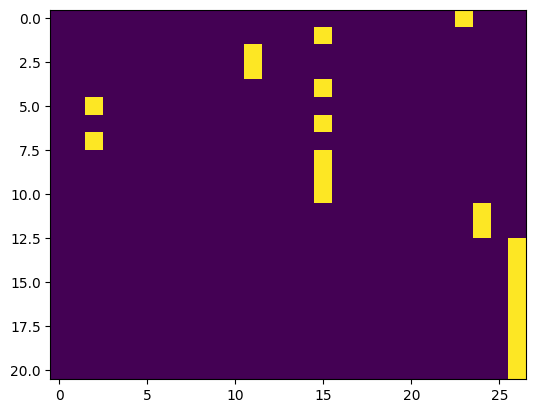

In [16]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

# Simple VAE

Here, we build a simple VAE to explore how the molecular properties are distributed in the 2D latent space.

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

This is one-hot encoded molecule object

In [18]:
molecules = np.array(one_hot_vectors)
print(molecules.shape)

(4993, 21, 27)


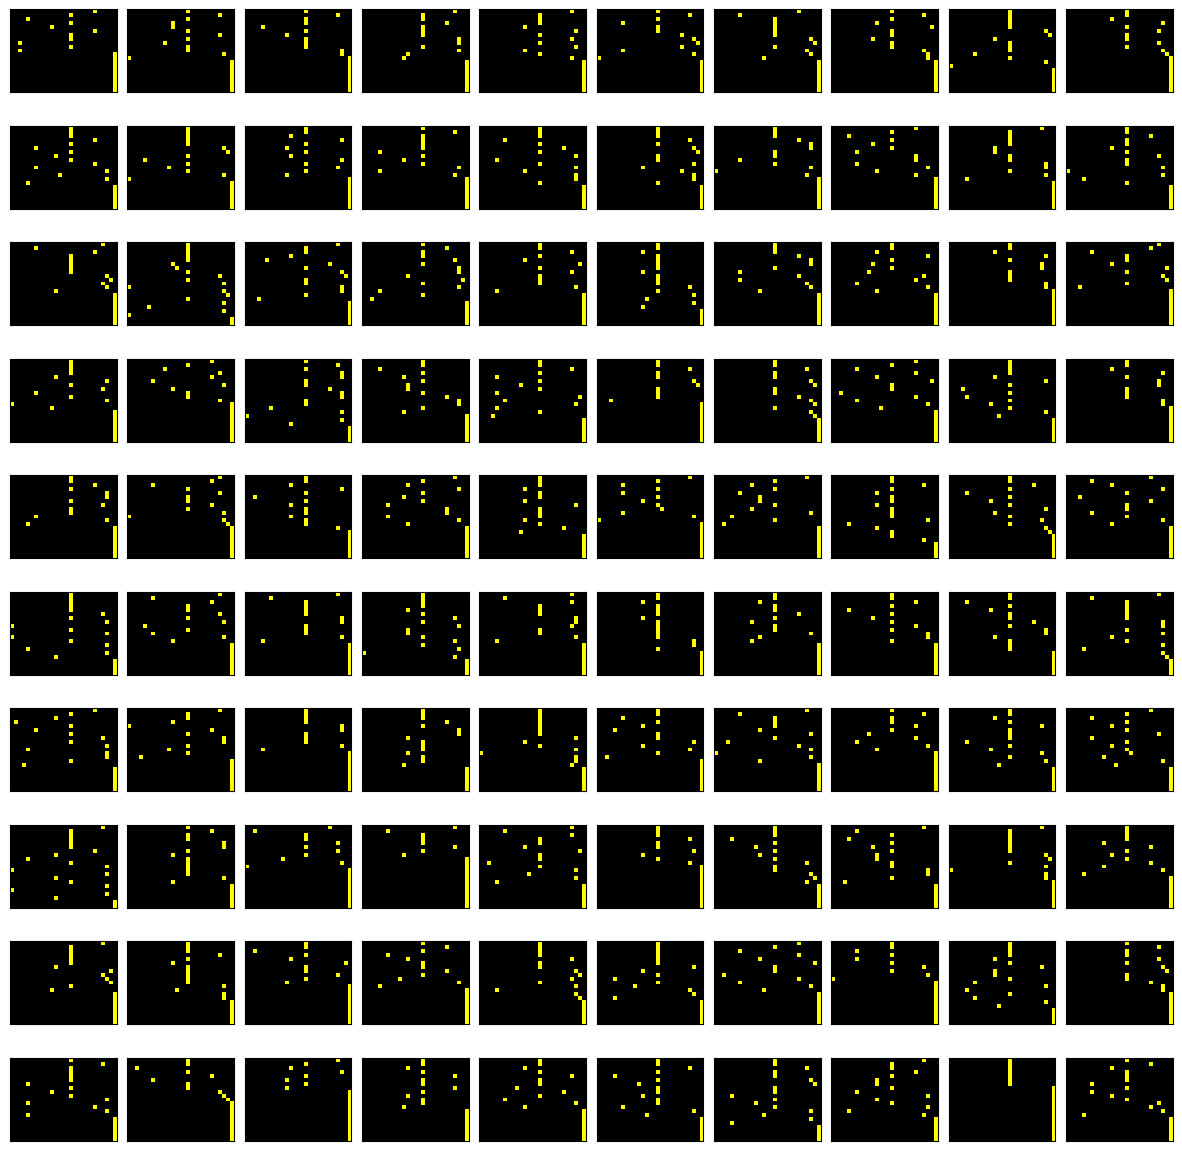

In [19]:
# Plotting random images
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(molecules))
    ax.imshow(molecules[i], cmap='gnuplot', interpolation = None)

In [20]:
input_shape = (molecules.shape[1], molecules.shape[2])
original_dim = np.prod(input_shape)
latent_dim = 2

# Encoder
inputs = Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(latent_inputs)
x = Dense(original_dim, activation='sigmoid')(x)
outputs = Reshape(input_shape)(x)

# Instantiate models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE Model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# VAE Loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs)) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [21]:
data = np.array(one_hot_vectors)
vae.fit(data, epochs=100, batch_size=64)

Epoch 1/100
79/79 [==============================] - 8s 4ms/step - loss: 189.5800
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 65.9105
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 49.1879
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 46.2473
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 44.8082
Epoch 6/100
79/79 [==============================] - 0s 4ms/step - loss: 43.8499
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 42.7072
Epoch 8/100
79/79 [==============================] - 0s 4ms/step - loss: 41.9204
Epoch 9/100
79/79 [==============================] - 0s 4ms/step - loss: 40.5782
Epoch 10/100
79/79 [==============================] - 0s 4ms/step - loss: 40.0739
Epoch 11/100
79/79 [==============================] - 0s 4ms/step - loss: 39.4506
Epoch 12/100
79/79 [==============================] - 0s 4ms/step - loss: 39.0154
Epoch 13/100
79/79 [====

In [22]:
def plot_latent_representation(decoder, height=21, width=27, n=15):
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)
    figure = np.zeros((height * n, width * n))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(height, width)
            figure[i * height: (i + 1) * height, j * width: (j + 1) * width] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('off')
    plt.show()


In [23]:
def plot_latent_space(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c = labels)
    plt.colorbar()
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.title('Latent Space')
    plt.show()


1/1 [==============================] - 0s 21ms/step


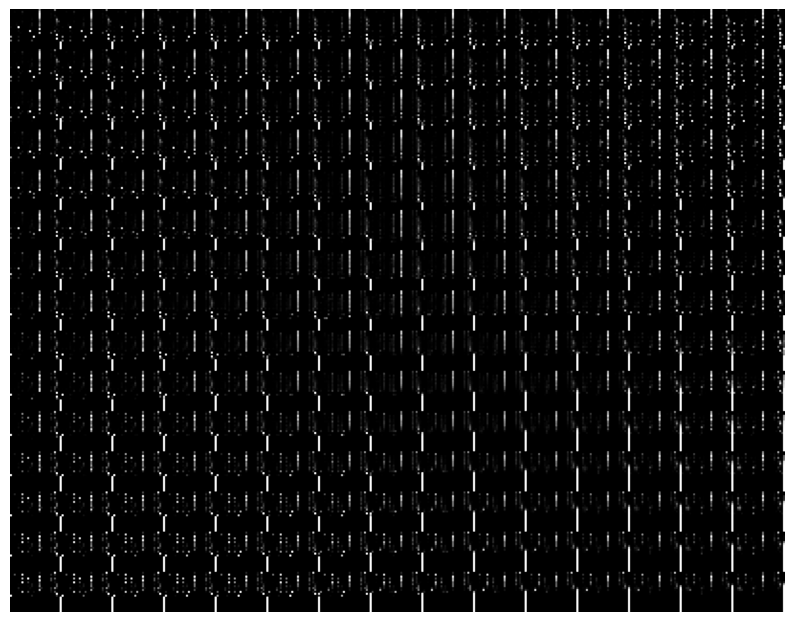

In [24]:
plot_latent_representation(decoder)

In [25]:
# If you would like to plot a single parameter
# plot_latent_space(encoder, data, df_filtered['dipole_moment'].values)

157/157 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Max Partial Charge')

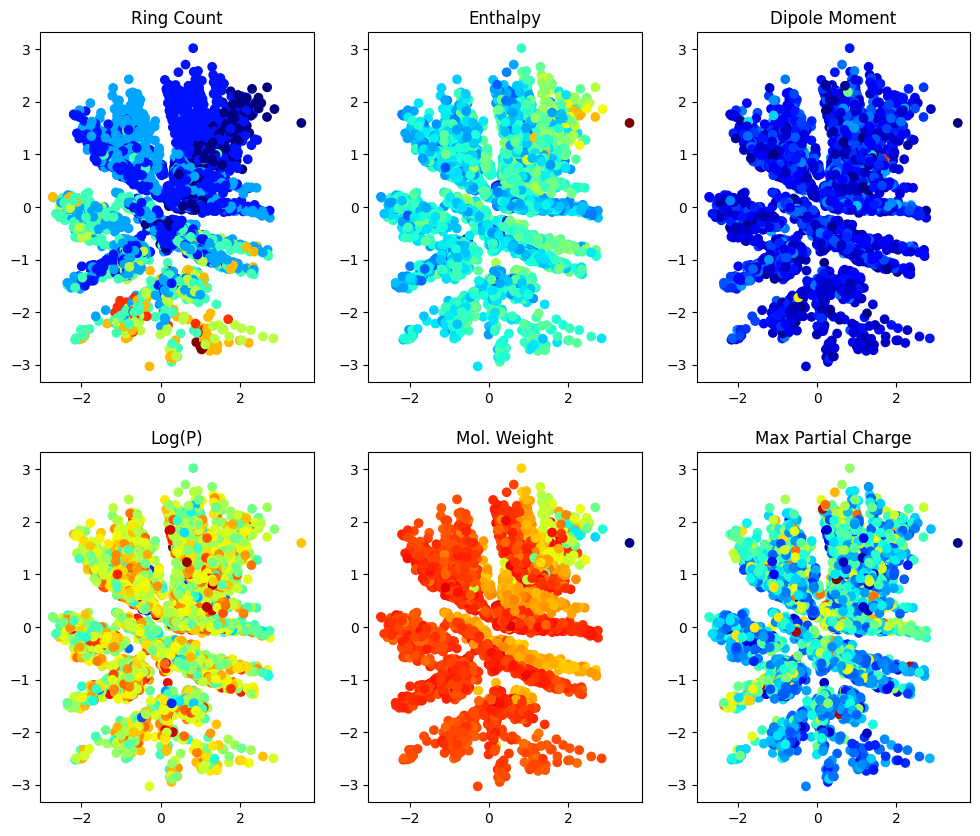

In [26]:
z_mean, _, _ = encoder.predict(data)

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12,10))
ax[0,0].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['ringct'], cmap='jet')
ax[0,0].set_title('Ring Count')
ax[0,1].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['enthalpy'], cmap='jet')
ax[0,1].set_title('Enthalpy')
ax[0,2].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['dipole_moment'], cmap='jet')
ax[0,2].set_title('Dipole Moment')
ax[1,0].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['mole_logp'], cmap='jet')
ax[1,0].set_title('Log(P)')
ax[1,1].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['mol_wt'], cmap='jet')
ax[1,1].set_title('Mol. Weight')
ax[1,2].scatter(z_mean[:, 0], z_mean[:, 1], c = df_filtered['max_partialcharge'], cmap='jet')
ax[1,2].set_title('Max Partial Charge')


Generally, we see that the represnetationsof the data set are disentangled. We see some clear correlations in Ring Count, Enthalpy, Molecular weight. Comparatively very little in Log(P) and Dipole Moment.

# DKL on molecules (2D latent space)

Here we explore the DKL to explore the molecule data set. We want to learn the function f(SELFIES) -> functionality.
- We can run DKL on the full data set to explore embeddings
- Or we can run the DKL as an active learning process - meaning that all the features are available (or equivalently our search space is defined), whereas targets are becoming available sequentially, as would be the case for (expensive) experiments. We should also define several useful variables, namely, the number of initial samples (for active learning), number of exploration steps, batch size for active learning (should be smaller then number of initial samples, or code will not work), and batch size for reconstructions. Parenthetically, batch size can be variable (so we can increase it when samples are becoming available).
- Keep in mind the DKL tries to minimize function. Add minus sign as appropriate

Adapted from notebook made for cards:
- References https://arxiv.org/abs/2303.14554
- Made by Mani Valleti, https://scholar.google.com/citations?hl=en&user=Jt7c5d4AAAAJ
- Based on GPax library by Maxim Ziatdinov, https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!



In [27]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 11.8 MB/s eta 0:00:00


In [28]:
import torch
import torch.nn as nn
tt = torch.tensor

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()

import pickle

## DKL on full dataset

If you are curious with this approach, it will be illustrative to run the code several times for different discovery/optimization targets. For example:
- Easy to recognize (number of rings)
- Reasonably systematic one (enthalpy)
- Difficult to recognize (dipole moment)

In [29]:
molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

#Actual target
targets5 = df_filtered['ringct'].values #mole_logp

'''
# Three alternative targets
targets1 = df_filtered['mole_logp'].values  #dipole_moment
targets2 = df_filtered['mol_wt'].values
targets3 = df_filtered['dipole_moment'].values
'''

(4993, 567)


"\n# Three alternative targets\ntargets1 = df_filtered['mole_logp'].values  #dipole_moment\ntargets2 = df_filtered['mol_wt'].values\ntargets3 = df_filtered['dipole_moment'].values\n"

In [30]:
X5 = np.copy(X)

rng_key_5, rng_key_predict_5 = gpax.utils.get_keys()
dkl_5 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_5.fit(rng_key_5, X5, targets5)

100%|██████████| 1000/1000 [02:04<00:00,  8.00it/s, init loss: 47469.6822, avg. loss [951-1000]: 31791.8854]



Inferred GP kernel parameters
k_length         [1.112  1.4945]
k_scale          5.7164
noise            0.0106


Now we see the DKL latent space with the Labels correpsonding to the target and several other parameters.

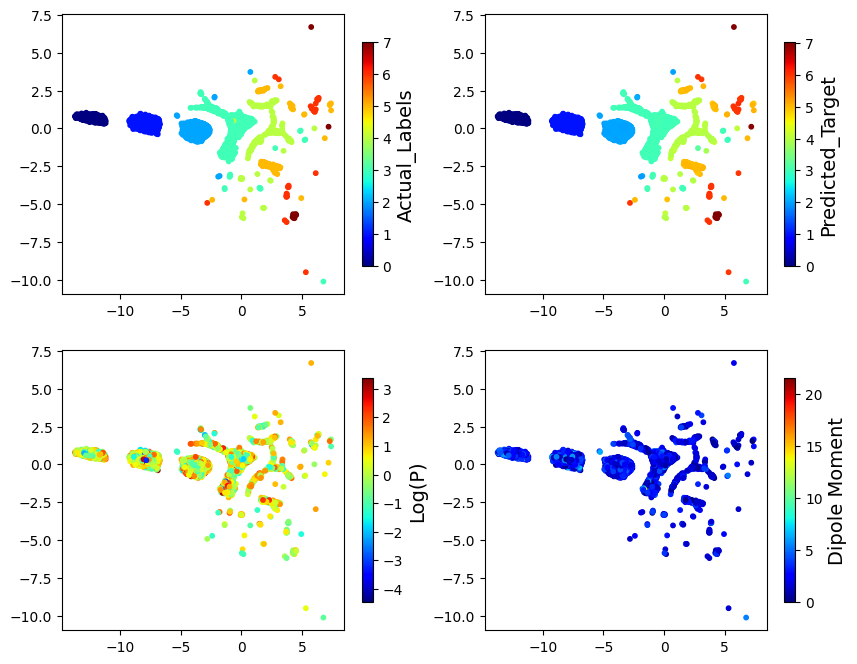

In [31]:
batch_size_reconstruct = 250

embeded_5 = dkl_5.embed(X5)
pred_mean5, pred_var5 = dkl_5.predict_in_batches(rng_key_predict_5, X5, batch_size=batch_size_reconstruct)
pred_std5 = jnp.sqrt(pred_var5)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = targets5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = pred_mean5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = df_filtered['mole_logp'].values,
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = df_filtered['dipole_moment'].values, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Dipole Moment", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Text(0.5, 1.0, 'Dipole Moment')

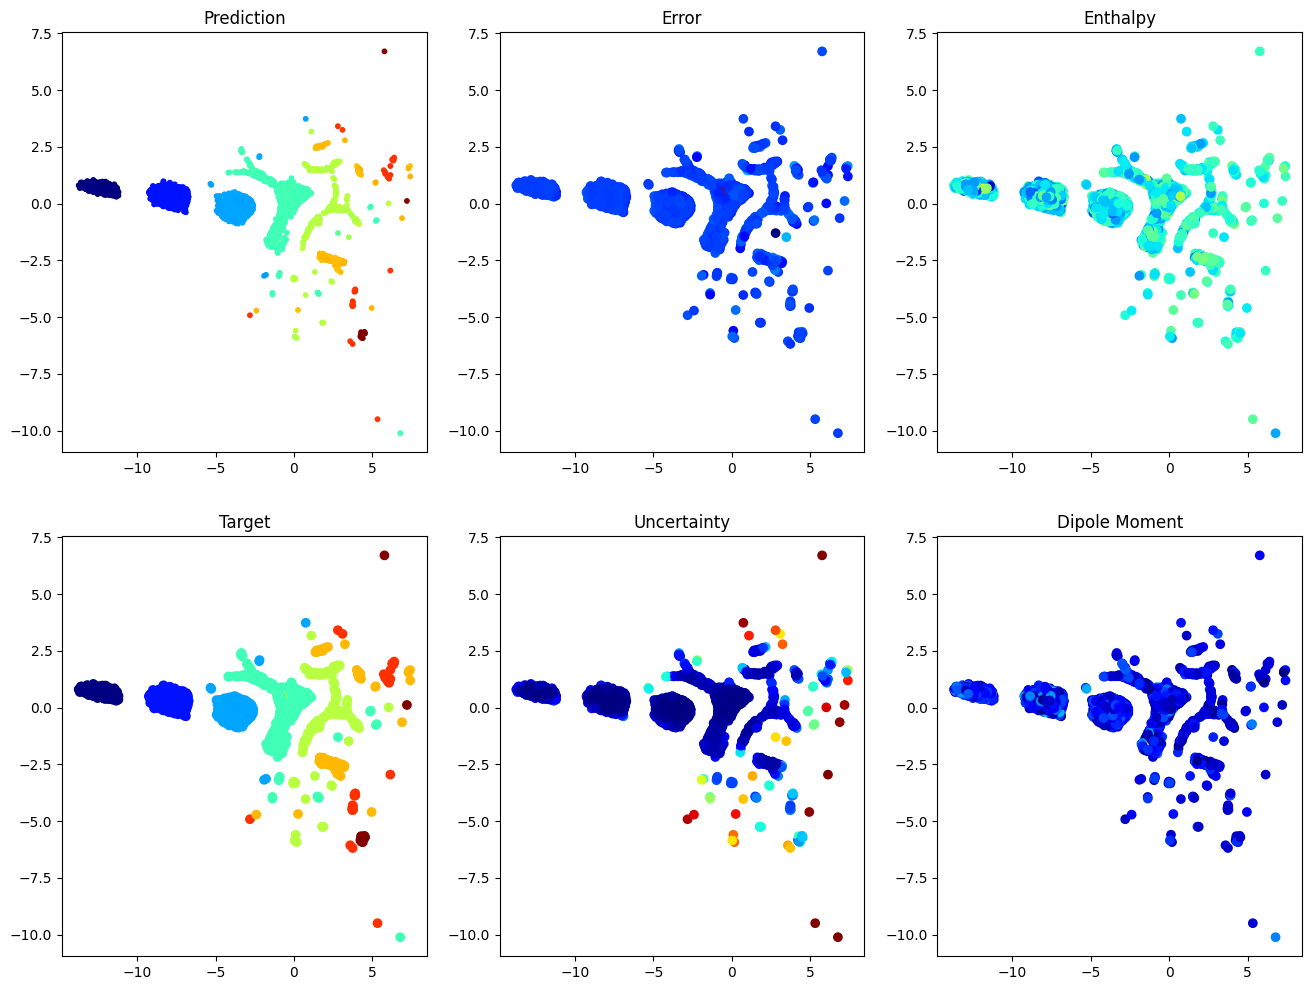

In [32]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16,12))
ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = pred_mean5, cmap='jet')
ax[0,0].set_title('Prediction')
ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], c = targets5 - pred_mean5, cmap='jet')
ax[0,1].set_title('Error')
ax[0,2].scatter(embeded_5[:, 1], embeded_5[:, 0], c = df_filtered['enthalpy'], cmap='jet')
ax[0,2].set_title('Enthalpy')
ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], c = targets5, cmap='jet')
ax[1,0].set_title('Target')
ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], c = pred_var5, cmap='jet')
ax[1,1].set_title('Uncertainty')
ax[1,2].scatter(embeded_5[:, 1], embeded_5[:, 0], c = df_filtered['dipole_moment'], cmap='jet')
ax[1,2].set_title('Dipole Moment')

This founction finds the 5 maximal points for a parameter we are interested in, and returns corresponding molecular structures

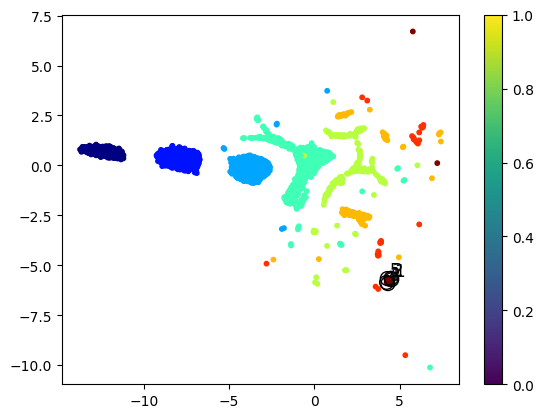

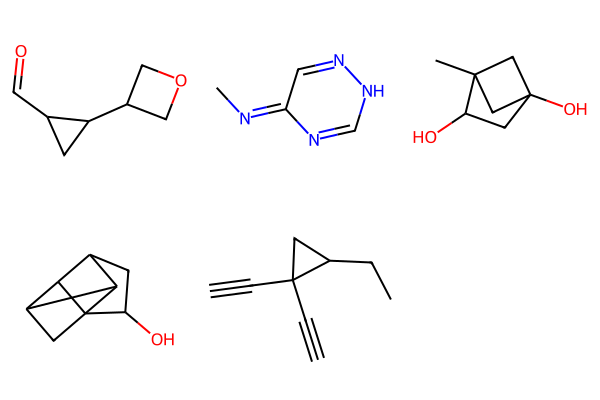

In [33]:
# Find indices of the 5 maximal points in pred_var5

expl_parameter = targets5 # - pred_mean5

max_indices = np.argsort(expl_parameter)[-5:]

# Plot the original scatter plot
plt.scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c=expl_parameter, cmap='jet')

# Plot circles and offset numbers around the 5 maximal points
for i, idx in enumerate(max_indices):
    plt.scatter(embeded_5[idx, 1], embeded_5[idx, 0], s=100, facecolors='none', edgecolors='black')
    # Offset the text slightly from the circle
    plt.text(embeded_5[idx, 1] + 0.12, embeded_5[idx, 0] + 0.18, str(i+1), color='black', fontsize=12)

plt.show()

# Retrieve rows from df corresponding to max_indices
maximal_rows = df.iloc[max_indices]

# Extract SMILES strings in the order of max_indices
smiles_list = maximal_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects in the same order
molecules_2 = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Annotate molecules with numbers corresponding to their order
for i, mol in enumerate(molecules_2):
    if mol is not None:
        mol.SetProp("_Name", str(i+1))

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules_2, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
img


Thsi function allows us to explore points separated by no less then minimal distance

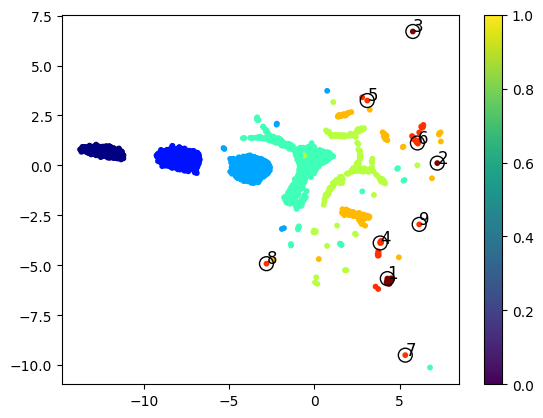

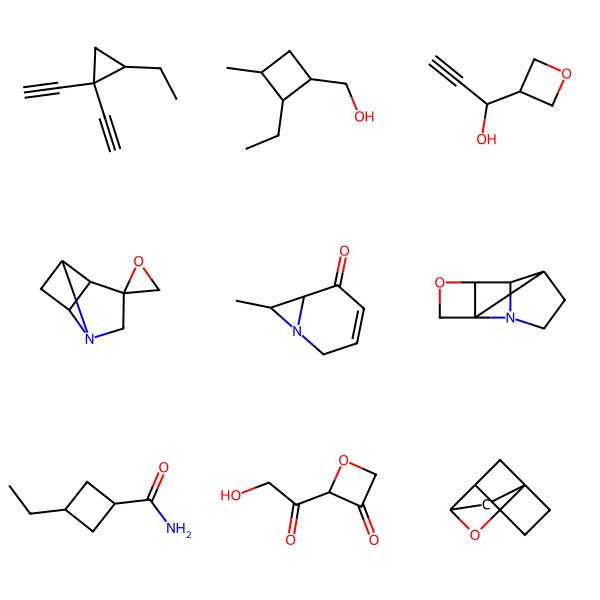

In [34]:
expl_parameter = targets5 #- pred_mean5
min_distance = 1  # Set a minimum distance, adjust as needed

def are_points_separated(point, other_points, min_distance):
    """Check if 'point' is at least 'min_distance' away from all points in 'other_points'."""
    return np.all(np.linalg.norm(other_points - point, axis=1) >= min_distance)

# Sort indices by descending pred_var5 value
sorted_indices = np.argsort(expl_parameter)[::-1]

max_indices = []

for idx in sorted_indices:
    if len(max_indices) >= 9:
        break
    point = embeded_5[idx]
    # Convert max_indices to a numpy array for proper indexing
    if not max_indices or are_points_separated(point, embeded_5[np.array(max_indices)], min_distance):
        max_indices.append(idx)

# Plot the original scatter plot
plt.scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c=expl_parameter, cmap='jet')

# Plot circles and numbers around the 5 maximal points
for i, idx in enumerate(max_indices):
    plt.scatter(embeded_5[idx, 1], embeded_5[idx, 0], s=100, facecolors='none', edgecolors='black')
    plt.text(embeded_5[idx, 1] + 0.01, embeded_5[idx, 0] + 0.01, str(i+1), color='black', fontsize=12)

plt.show()

# Retrieve rows from df corresponding to max_indices
maximal_rows = df.iloc[max_indices]

# Extract SMILES strings in the order of max_indices
smiles_list = maximal_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects in the same order
molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Annotate molecules with numbers corresponding to their order
for i, mol in enumerate(molecules):
    if mol is not None:
        mol.SetProp("_Name", str(i+1))

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
img

And this one selects points close to one of the selected maxima

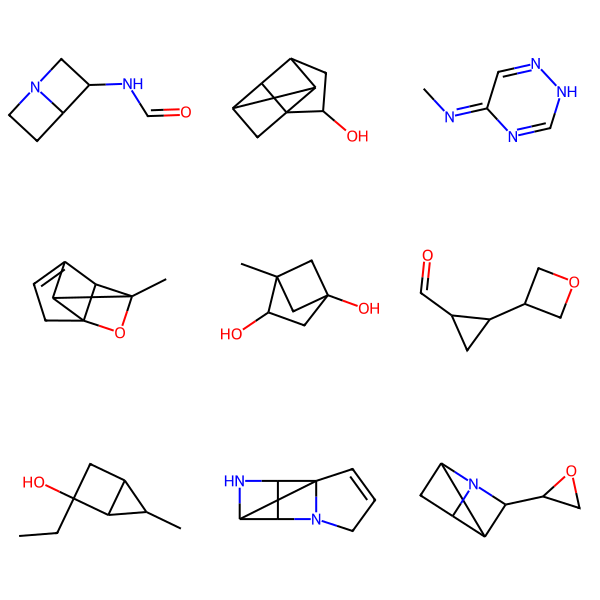

In [35]:
selected_max_idx = max_indices[0]  # Selecting the first maximum for demonstration

def find_nearest_neighbors(reference_idx, embedding, num_neighbors=9):
    """Find the indices of the nearest neighbors to a reference point."""
    reference_point = embedding[reference_idx]
    distances = distance.cdist([reference_point], embedding, 'euclidean').flatten()
    nearest_indices = np.argsort(distances)[1:num_neighbors+1]  # Exclude the reference point itself
    return nearest_indices

# Selecting a maximum and finding nearest neighbors
neighbor_indices = find_nearest_neighbors(selected_max_idx, embeded_5)
neighbor_rows = df.iloc[neighbor_indices]
neighbor_smiles = neighbor_rows['smiles'].tolist()
neighbor_molecules = [Chem.MolFromSmiles(smile) for smile in neighbor_smiles]
neighbor_img = Draw.MolsToGridImage(neighbor_molecules, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
neighbor_img

## Active learning

Note that we should be careful withthe target choice selecting the minus sign when appropriate. For example,
- targets5 = - df_filtered['ringct'].values will look for linear molecules
- targets5 = df_filtered['ringct'].values will look for maximal amount of loops

In [36]:
molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

#Actual target
targets5 = - df_filtered['ringct'].values #mole_logp dipole_moment

(4993, 567)


In [37]:
init_num = 200
exp_step = 200
batch_size_learn = 10 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

In [38]:
np.random.seed(0)
idx5 = np.random.choice(np.arange(len(X5)), size = init_num, replace = False)
X5_train = X5[idx5]
X5_unmeasured = np.delete(X5, idx5, axis=0)

indices_total_5 = np.arange(len(X))
indices_train_5 = indices_total_5[idx5]
y5_train = targets5[idx5]
indices_unmeasured_5 = np.delete(indices_total_5, idx5)

In [39]:
exp_mean5, exp_std5 = [], []
dkl_mean5, dkl_std5 = [], []
embed_traj5 = []
traj_mean5, traj_std5 = [], []

exploration_steps = exp_step

for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key15, rng_key_predict15 = gpax.utils.get_keys()
    dkl_BO_5 = gpax.viDKL(s2*s3, 2, 'RBF')
    dkl_BO_5.fit(rng_key15, X5_train, y5_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean5.append(y_mean[id_next])
    exp_std5.append(y_std[id_next])

    x_next = X5_unmeasured[id_next]
    ind_next = indices_unmeasured_5[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean5.append(pred_mean5[ind_next])
    dkl_std5.append(pred_std5[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets5[ind_next]

    # Update training arrays
    X5_train = np.append(X5_train, x_next[None], axis=0)
    y5_train = np.append(y5_train, y_measured)
    X5_unmeasured = np.delete(X5_unmeasured, id_next, axis=0)
    indices_unmeasured_5 = np.delete(indices_unmeasured_5, id_next)

    embed_traj = dkl_BO_5.embed(X5_train)
    traj_m, traj_s = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_train, batch_size=batch_size_learn)

    embed_traj5.append(embed_traj)
    traj_mean5.append(traj_m)
    traj_std5.append(traj_s)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 346.75it/s, init loss: 39784.9071, avg. loss [951-1000]: 37211.8671]



Inferred GP kernel parameters
k_length         [1.0362 1.9109]
k_scale          5.4105
noise            0.0097

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 342.46it/s, init loss: 39786.8052, avg. loss [951-1000]: 37176.8114]



Inferred GP kernel parameters
k_length         [1.1582 1.4555]
k_scale          5.6909
noise            0.0097

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 348.85it/s, init loss: 39788.4532, avg. loss [951-1000]: 37160.5077]



Inferred GP kernel parameters
k_length         [1.1238 1.8498]
k_scale          4.9973
noise            0.0083

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 346.31it/s, init loss: 39790.5249, avg. loss [951-1000]: 37175.1662]



Inferred GP kernel parameters
k_length         [1.1399 1.3227]
k_scale          5.4564
noise            0.008

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 351.11it/s, init loss: 39792.5112, avg. loss [951-1000]: 37143.0501]



Inferred GP kernel parameters
k_length         [1.1148 1.5566]
k_scale          5.5558000000000005
noise            0.008

Step 6


100%|██████████| 1000/1000 [00:03<00:00, 299.12it/s, init loss: 39793.7676, avg. loss [951-1000]: 37856.7899]



Inferred GP kernel parameters
k_length         [0.4286 1.0041]
k_scale          5.9562
noise            0.0171

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 342.92it/s, init loss: 39794.9039, avg. loss [951-1000]: 37213.2385]



Inferred GP kernel parameters
k_length         [0.9466 1.3997]
k_scale          5.7860000000000005
noise            0.0145

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 347.74it/s, init loss: 39796.3359, avg. loss [951-1000]: 37162.2778]



Inferred GP kernel parameters
k_length         [1.8513 1.5514]
k_scale          5.018400000000001
noise            0.0102

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 356.51it/s, init loss: 39798.6241, avg. loss [951-1000]: 37166.7594]



Inferred GP kernel parameters
k_length         [1.2193 1.2011]
k_scale          6.3485000000000005
noise            0.0099

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 333.76it/s, init loss: 39800.7795, avg. loss [951-1000]: 37135.8110]



Inferred GP kernel parameters
k_length         [0.9662 2.011 ]
k_scale          5.613300000000001
noise            0.009000000000000001

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 333.97it/s, init loss: 39802.4645, avg. loss [951-1000]: 37127.8969]



Inferred GP kernel parameters
k_length         [1.4103 2.0401]
k_scale          4.8409
noise            0.0076

Step 12


100%|██████████| 1000/1000 [00:03<00:00, 282.19it/s, init loss: 39804.3225, avg. loss [951-1000]: 37140.0359]



Inferred GP kernel parameters
k_length         [0.9982 1.4434]
k_scale          6.1686000000000005
noise            0.0081

Step 13


100%|██████████| 1000/1000 [00:03<00:00, 332.50it/s, init loss: 39805.8436, avg. loss [951-1000]: 37128.7081]



Inferred GP kernel parameters
k_length         [1.1232 2.099 ]
k_scale          5.7919
noise            0.0083

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 340.91it/s, init loss: 39807.2820, avg. loss [951-1000]: 37128.1436]



Inferred GP kernel parameters
k_length         [0.7124 1.4114]
k_scale          5.5183
noise            0.007500000000000001

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 345.85it/s, init loss: 39809.1305, avg. loss [951-1000]: 37349.8312]



Inferred GP kernel parameters
k_length         [0.7373 0.8973]
k_scale          5.4886
noise            0.0184

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 337.43it/s, init loss: 39810.7862, avg. loss [951-1000]: 37406.4068]



Inferred GP kernel parameters
k_length         [0.821 0.993]
k_scale          6.6928
noise            0.0247

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 340.92it/s, init loss: 39812.1321, avg. loss [951-1000]: 37206.1188]



Inferred GP kernel parameters
k_length         [0.9103 1.1523]
k_scale          7.626200000000001
noise            0.011600000000000001

Step 18


100%|██████████| 1000/1000 [00:03<00:00, 332.92it/s, init loss: 39819.5816, avg. loss [951-1000]: 37863.5138]



Inferred GP kernel parameters
k_length         [0.4898 1.2327]
k_scale          5.8821
noise            0.0134

Step 19


100%|██████████| 1000/1000 [00:03<00:00, 277.41it/s, init loss: 39821.0238, avg. loss [951-1000]: 37160.2867]



Inferred GP kernel parameters
k_length         [1.3993 1.717 ]
k_scale          4.8624
noise            0.0111

Step 20


100%|██████████| 1000/1000 [00:03<00:00, 326.46it/s, init loss: 39822.4202, avg. loss [951-1000]: 37183.1251]



Inferred GP kernel parameters
k_length         [0.9692 1.2877]
k_scale          7.3837
noise            0.011300000000000001

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 333.78it/s, init loss: 39824.5576, avg. loss [951-1000]: 37124.1193]



Inferred GP kernel parameters
k_length         [1.2925 1.9706]
k_scale          5.1424
noise            0.0085

Step 22


100%|██████████| 1000/1000 [00:03<00:00, 327.02it/s, init loss: 39827.2113, avg. loss [951-1000]: 37142.3826]



Inferred GP kernel parameters
k_length         [0.8843 1.7149]
k_scale          5.9543
noise            0.0089

Step 23


100%|██████████| 1000/1000 [00:03<00:00, 323.56it/s, init loss: 39831.2749, avg. loss [951-1000]: 37318.9917]



Inferred GP kernel parameters
k_length         [0.9553 0.8862]
k_scale          8.157300000000001
noise            0.015600000000000001

Step 24


100%|██████████| 1000/1000 [00:03<00:00, 329.65it/s, init loss: 39834.0095, avg. loss [951-1000]: 37189.4868]



Inferred GP kernel parameters
k_length         [1.0602 1.1793]
k_scale          5.561
noise            0.011000000000000001

Step 25


100%|██████████| 1000/1000 [00:03<00:00, 332.95it/s, init loss: 39835.3488, avg. loss [951-1000]: 37300.7148]



Inferred GP kernel parameters
k_length         [1.0106 1.0108]
k_scale          8.4158
noise            0.0178

Step 26


100%|██████████| 1000/1000 [00:03<00:00, 328.57it/s, init loss: 39837.4248, avg. loss [951-1000]: 37145.5783]



Inferred GP kernel parameters
k_length         [1.2044 2.1299]
k_scale          6.0327
noise            0.010100000000000001

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 335.77it/s, init loss: 39839.1417, avg. loss [951-1000]: 37296.7745]



Inferred GP kernel parameters
k_length         [0.6898 1.4304]
k_scale          7.5286
noise            0.016

Step 28


100%|██████████| 1000/1000 [00:03<00:00, 330.37it/s, init loss: 39843.6263, avg. loss [951-1000]: 37273.3001]



Inferred GP kernel parameters
k_length         [0.9172 1.1612]
k_scale          5.5902
noise            0.0166

Step 29


100%|██████████| 1000/1000 [00:03<00:00, 330.82it/s, init loss: 39845.1166, avg. loss [951-1000]: 37181.7644]



Inferred GP kernel parameters
k_length         [1.1268 1.2855]
k_scale          5.6065000000000005
noise            0.012

Step 30


100%|██████████| 1000/1000 [00:03<00:00, 324.39it/s, init loss: 39846.6647, avg. loss [951-1000]: 37178.1690]



Inferred GP kernel parameters
k_length         [1.3215 0.8774]
k_scale          6.107600000000001
noise            0.0126

Step 31


100%|██████████| 1000/1000 [00:03<00:00, 322.10it/s, init loss: 39848.5801, avg. loss [951-1000]: 37096.4423]



Inferred GP kernel parameters
k_length         [1.9171 2.5803]
k_scale          4.646100000000001
noise            0.007500000000000001

Step 32


100%|██████████| 1000/1000 [00:03<00:00, 326.69it/s, init loss: 39850.3353, avg. loss [951-1000]: 37129.1303]



Inferred GP kernel parameters
k_length         [1.2639 2.3021]
k_scale          4.9144000000000005
noise            0.0099

Step 33


100%|██████████| 1000/1000 [00:03<00:00, 299.67it/s, init loss: 39851.8631, avg. loss [951-1000]: 37272.1610]



Inferred GP kernel parameters
k_length         [1.0242 1.6912]
k_scale          6.1775
noise            0.0161

Step 34


100%|██████████| 1000/1000 [00:03<00:00, 283.21it/s, init loss: 39857.4629, avg. loss [951-1000]: 37340.1584]



Inferred GP kernel parameters
k_length         [1.1607 1.0736]
k_scale          5.4527
noise            0.0158

Step 35


100%|██████████| 1000/1000 [00:03<00:00, 322.73it/s, init loss: 39858.8765, avg. loss [951-1000]: 37156.9908]



Inferred GP kernel parameters
k_length         [1.0588 1.4726]
k_scale          6.3303
noise            0.0089

Step 36


100%|██████████| 1000/1000 [00:03<00:00, 328.40it/s, init loss: 39860.5549, avg. loss [951-1000]: 37201.1506]



Inferred GP kernel parameters
k_length         [0.6744 1.1519]
k_scale          6.766
noise            0.012100000000000001

Step 37


100%|██████████| 1000/1000 [00:03<00:00, 308.38it/s, init loss: 39861.9437, avg. loss [951-1000]: 37145.3237]



Inferred GP kernel parameters
k_length         [1.5797 1.1317]
k_scale          6.0713
noise            0.010700000000000001

Step 38


100%|██████████| 1000/1000 [00:03<00:00, 323.93it/s, init loss: 39863.6321, avg. loss [951-1000]: 37569.4283]



Inferred GP kernel parameters
k_length         [0.8559 1.2401]
k_scale          6.9569
noise            0.016300000000000002

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 336.73it/s, init loss: 39865.4191, avg. loss [951-1000]: 37138.0071]



Inferred GP kernel parameters
k_length         [1.3373 1.6208]
k_scale          5.9363
noise            0.0094

Step 40


100%|██████████| 1000/1000 [00:03<00:00, 332.11it/s, init loss: 39867.2560, avg. loss [951-1000]: 37126.8383]



Inferred GP kernel parameters
k_length         [1.4191 1.9698]
k_scale          6.2753000000000005
noise            0.0095

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 337.16it/s, init loss: 39868.7954, avg. loss [951-1000]: 37109.9896]



Inferred GP kernel parameters
k_length         [1.0862 2.2144]
k_scale          5.6338
noise            0.008400000000000001

Step 42


100%|██████████| 1000/1000 [00:03<00:00, 320.15it/s, init loss: 39870.8752, avg. loss [951-1000]: 37444.9226]



Inferred GP kernel parameters
k_length         [1.1561 1.2344]
k_scale          4.6477
noise            0.0273

Step 43


100%|██████████| 1000/1000 [00:03<00:00, 327.13it/s, init loss: 39872.9822, avg. loss [951-1000]: 38101.7995]



Inferred GP kernel parameters
k_length         [0.7384 0.652 ]
k_scale          5.8933
noise            0.018600000000000002

Step 44


100%|██████████| 1000/1000 [00:03<00:00, 327.66it/s, init loss: 39874.3476, avg. loss [951-1000]: 37256.7393]



Inferred GP kernel parameters
k_length         [1.3211 1.0722]
k_scale          5.5784
noise            0.0159

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 336.50it/s, init loss: 39888.9736, avg. loss [951-1000]: 37406.3567]



Inferred GP kernel parameters
k_length         [0.9375 1.063 ]
k_scale          6.458900000000001
noise            0.021400000000000002

Step 46


100%|██████████| 1000/1000 [00:03<00:00, 326.53it/s, init loss: 39891.9037, avg. loss [951-1000]: 37087.0249]



Inferred GP kernel parameters
k_length         [2.0529 2.4373]
k_scale          4.6455
noise            0.0081

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 335.85it/s, init loss: 39893.5395, avg. loss [951-1000]: 37146.1950]



Inferred GP kernel parameters
k_length         [1.3486 1.5525]
k_scale          6.2633
noise            0.0095

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 336.74it/s, init loss: 39894.6262, avg. loss [951-1000]: 37137.3892]



Inferred GP kernel parameters
k_length         [0.9458 1.434 ]
k_scale          6.0746
noise            0.0088

Step 49


100%|██████████| 1000/1000 [00:03<00:00, 327.32it/s, init loss: 39896.4374, avg. loss [951-1000]: 37122.4722]



Inferred GP kernel parameters
k_length         [1.3352 2.0282]
k_scale          6.6585
noise            0.008400000000000001

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 333.84it/s, init loss: 39899.1003, avg. loss [951-1000]: 37076.3346]



Inferred GP kernel parameters
k_length         [1.8985 2.5651]
k_scale          4.5407
noise            0.0079

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 337.91it/s, init loss: 39901.3314, avg. loss [951-1000]: 37214.6506]



Inferred GP kernel parameters
k_length         [1.0578 1.382 ]
k_scale          6.3459
noise            0.0149

Step 52


100%|██████████| 1000/1000 [00:03<00:00, 320.89it/s, init loss: 39902.4509, avg. loss [951-1000]: 37142.6124]



Inferred GP kernel parameters
k_length         [1.9264 1.1433]
k_scale          6.2683
noise            0.009600000000000001

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 334.08it/s, init loss: 39903.6575, avg. loss [951-1000]: 37143.6189]



Inferred GP kernel parameters
k_length         [1.1206 1.3214]
k_scale          6.589300000000001
noise            0.0085

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 336.27it/s, init loss: 39905.2607, avg. loss [951-1000]: 37176.2369]



Inferred GP kernel parameters
k_length         [1.3338 1.1891]
k_scale          7.1427000000000005
noise            0.010400000000000001

Step 55


100%|██████████| 1000/1000 [00:03<00:00, 322.80it/s, init loss: 39909.1556, avg. loss [951-1000]: 37133.4033]



Inferred GP kernel parameters
k_length         [1.0702 1.7314]
k_scale          6.3074
noise            0.011600000000000001

Step 56


100%|██████████| 1000/1000 [00:03<00:00, 328.18it/s, init loss: 39910.9641, avg. loss [951-1000]: 37756.6237]



Inferred GP kernel parameters
k_length         [0.7485 0.516 ]
k_scale          7.154
noise            0.0129

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 336.67it/s, init loss: 39912.0457, avg. loss [951-1000]: 37542.9086]



Inferred GP kernel parameters
k_length         [1.0201 1.4245]
k_scale          7.6401
noise            0.0112

Step 58


100%|██████████| 1000/1000 [00:03<00:00, 312.01it/s, init loss: 39913.2316, avg. loss [951-1000]: 37112.4065]



Inferred GP kernel parameters
k_length         [1.8386 2.2872]
k_scale          4.8539
noise            0.009300000000000001

Step 59


100%|██████████| 1000/1000 [00:03<00:00, 318.10it/s, init loss: 39915.2240, avg. loss [951-1000]: 37396.0225]



Inferred GP kernel parameters
k_length         [1.1616 1.0353]
k_scale          6.4751
noise            0.0143

Step 60


100%|██████████| 1000/1000 [00:03<00:00, 325.03it/s, init loss: 39917.3572, avg. loss [951-1000]: 37150.9434]



Inferred GP kernel parameters
k_length         [1.0946 1.5222]
k_scale          5.9969
noise            0.0088

Step 61


100%|██████████| 1000/1000 [00:03<00:00, 321.34it/s, init loss: 39919.0977, avg. loss [951-1000]: 37148.1309]



Inferred GP kernel parameters
k_length         [1.5339 1.7183]
k_scale          7.170400000000001
noise            0.0117

Step 62


100%|██████████| 1000/1000 [00:03<00:00, 314.20it/s, init loss: 39920.5531, avg. loss [951-1000]: 37117.4993]



Inferred GP kernel parameters
k_length         [1.0412 1.8251]
k_scale          8.112
noise            0.0089

Step 63


100%|██████████| 1000/1000 [00:03<00:00, 322.58it/s, init loss: 39924.9811, avg. loss [951-1000]: 37134.5553]



Inferred GP kernel parameters
k_length         [1.3897 0.935 ]
k_scale          7.453600000000001
noise            0.009300000000000001

Step 64


100%|██████████| 1000/1000 [00:03<00:00, 319.50it/s, init loss: 39929.4652, avg. loss [951-1000]: 37138.9062]



Inferred GP kernel parameters
k_length         [1.2148 1.6447]
k_scale          6.6635
noise            0.010700000000000001

Step 65


100%|██████████| 1000/1000 [00:03<00:00, 309.22it/s, init loss: 39931.5694, avg. loss [951-1000]: 37111.7328]



Inferred GP kernel parameters
k_length         [1.0465 1.5431]
k_scale          5.2883000000000004
noise            0.009600000000000001

Step 66


100%|██████████| 1000/1000 [00:03<00:00, 319.55it/s, init loss: 39933.2622, avg. loss [951-1000]: 37091.7603]



Inferred GP kernel parameters
k_length         [1.3283 2.4531]
k_scale          6.3674
noise            0.0086

Step 67


100%|██████████| 1000/1000 [00:04<00:00, 235.56it/s, init loss: 39934.8096, avg. loss [951-1000]: 37081.3807]



Inferred GP kernel parameters
k_length         [2.8297 1.5464]
k_scale          4.6885
noise            0.008700000000000001

Step 68


100%|██████████| 1000/1000 [00:03<00:00, 318.96it/s, init loss: 39936.1583, avg. loss [951-1000]: 37079.5034]



Inferred GP kernel parameters
k_length         [1.5192 2.9806]
k_scale          6.7917000000000005
noise            0.0088

Step 69


100%|██████████| 1000/1000 [00:03<00:00, 318.86it/s, init loss: 39938.0822, avg. loss [951-1000]: 37138.2486]



Inferred GP kernel parameters
k_length         [1.1779 1.9027]
k_scale          7.4274000000000004
noise            0.0105

Step 70


100%|██████████| 1000/1000 [00:03<00:00, 317.86it/s, init loss: 39939.1800, avg. loss [951-1000]: 37243.5720]



Inferred GP kernel parameters
k_length         [1.0114 1.2525]
k_scale          6.1547
noise            0.014100000000000001

Step 71


100%|██████████| 1000/1000 [00:03<00:00, 317.76it/s, init loss: 39940.4095, avg. loss [951-1000]: 37113.0735]



Inferred GP kernel parameters
k_length         [1.566  1.6856]
k_scale          5.2173
noise            0.0098

Step 72


100%|██████████| 1000/1000 [00:03<00:00, 322.76it/s, init loss: 39942.1549, avg. loss [951-1000]: 37101.5979]



Inferred GP kernel parameters
k_length         [1.6147 2.224 ]
k_scale          5.2944
noise            0.0097

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 338.13it/s, init loss: 39943.4177, avg. loss [951-1000]: 37155.2077]



Inferred GP kernel parameters
k_length         [1.1131 1.5251]
k_scale          6.3669
noise            0.011000000000000001

Step 74


100%|██████████| 1000/1000 [00:03<00:00, 313.89it/s, init loss: 39950.3385, avg. loss [951-1000]: 37109.1388]



Inferred GP kernel parameters
k_length         [2.2584 1.6373]
k_scale          6.1902
noise            0.0092

Step 75


100%|██████████| 1000/1000 [00:03<00:00, 315.41it/s, init loss: 39952.3961, avg. loss [951-1000]: 37146.5497]



Inferred GP kernel parameters
k_length         [1.7629 1.2266]
k_scale          6.155600000000001
noise            0.0117

Step 76


100%|██████████| 1000/1000 [00:03<00:00, 320.05it/s, init loss: 39953.4839, avg. loss [951-1000]: 37317.8168]



Inferred GP kernel parameters
k_length         [1.4277 1.008 ]
k_scale          6.0563
noise            0.0212

Step 77


100%|██████████| 1000/1000 [00:03<00:00, 324.09it/s, init loss: 39955.3387, avg. loss [951-1000]: 37088.5596]



Inferred GP kernel parameters
k_length         [1.3148 3.2166]
k_scale          6.488
noise            0.009300000000000001

Step 78


100%|██████████| 1000/1000 [00:03<00:00, 311.97it/s, init loss: 39957.0032, avg. loss [951-1000]: 37160.9441]



Inferred GP kernel parameters
k_length         [1.0605 1.5277]
k_scale          5.865600000000001
noise            0.0131

Step 79


100%|██████████| 1000/1000 [00:03<00:00, 321.11it/s, init loss: 39959.4417, avg. loss [951-1000]: 37290.0436]



Inferred GP kernel parameters
k_length         [0.949  0.9808]
k_scale          6.995500000000001
noise            0.0205

Step 80


100%|██████████| 1000/1000 [00:03<00:00, 318.69it/s, init loss: 39969.6270, avg. loss [951-1000]: 37146.5836]



Inferred GP kernel parameters
k_length         [1.0332 2.2123]
k_scale          6.709300000000001
noise            0.0097

Step 81


100%|██████████| 1000/1000 [00:03<00:00, 318.37it/s, init loss: 39973.6370, avg. loss [951-1000]: 37178.9042]



Inferred GP kernel parameters
k_length         [2.2563 1.176 ]
k_scale          6.2634
noise            0.0148

Step 82


100%|██████████| 1000/1000 [00:03<00:00, 317.57it/s, init loss: 39974.7642, avg. loss [951-1000]: 37075.5111]



Inferred GP kernel parameters
k_length         [2.6266 2.9482]
k_scale          4.3373
noise            0.0094

Step 83


100%|██████████| 1000/1000 [00:03<00:00, 318.09it/s, init loss: 39976.4826, avg. loss [951-1000]: 37124.3959]



Inferred GP kernel parameters
k_length         [0.9302 2.3678]
k_scale          6.251
noise            0.010700000000000001

Step 84


100%|██████████| 1000/1000 [00:03<00:00, 308.23it/s, init loss: 39978.2174, avg. loss [951-1000]: 37124.8067]



Inferred GP kernel parameters
k_length         [1.8393 1.5812]
k_scale          5.9133000000000004
noise            0.0106

Step 85


100%|██████████| 1000/1000 [00:03<00:00, 315.35it/s, init loss: 39980.2550, avg. loss [951-1000]: 37158.9220]



Inferred GP kernel parameters
k_length         [0.9974 2.7766]
k_scale          7.3843000000000005
noise            0.0129

Step 86


100%|██████████| 1000/1000 [00:03<00:00, 320.61it/s, init loss: 39986.1638, avg. loss [951-1000]: 37080.1528]



Inferred GP kernel parameters
k_length         [1.7346 2.4773]
k_scale          6.1294
noise            0.0103

Step 87


100%|██████████| 1000/1000 [00:03<00:00, 322.14it/s, init loss: 39988.0024, avg. loss [951-1000]: 37158.4005]



Inferred GP kernel parameters
k_length         [1.0578 2.6122]
k_scale          6.966
noise            0.0099

Step 88


100%|██████████| 1000/1000 [00:03<00:00, 315.97it/s, init loss: 39992.2949, avg. loss [951-1000]: 37118.6262]



Inferred GP kernel parameters
k_length         [1.4515 2.0359]
k_scale          5.244000000000001
noise            0.0112

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 338.20it/s, init loss: 39994.0928, avg. loss [951-1000]: 37225.1641]



Inferred GP kernel parameters
k_length         [0.9567 1.3084]
k_scale          6.7551000000000005
noise            0.0151

Step 90


100%|██████████| 1000/1000 [00:03<00:00, 304.80it/s, init loss: 40008.4459, avg. loss [951-1000]: 37392.0505]



Inferred GP kernel parameters
k_length         [0.933  1.8052]
k_scale          7.4106000000000005
noise            0.014400000000000001

Step 91


100%|██████████| 1000/1000 [00:03<00:00, 310.32it/s, init loss: 40011.3523, avg. loss [951-1000]: 37121.8528]



Inferred GP kernel parameters
k_length         [2.2298 2.481 ]
k_scale          4.5218
noise            0.0086

Step 92


100%|██████████| 1000/1000 [00:04<00:00, 216.73it/s, init loss: 40012.9635, avg. loss [951-1000]: 37063.2654]



Inferred GP kernel parameters
k_length         [2.1813 3.2126]
k_scale          4.4484
noise            0.0079

Step 93


100%|██████████| 1000/1000 [00:03<00:00, 310.42it/s, init loss: 40014.7254, avg. loss [951-1000]: 37078.1805]



Inferred GP kernel parameters
k_length         [3.3002 2.3205]
k_scale          4.3396
noise            0.0086

Step 94


100%|██████████| 1000/1000 [00:03<00:00, 298.31it/s, init loss: 40016.2998, avg. loss [951-1000]: 37216.5325]



Inferred GP kernel parameters
k_length         [1.3299 1.0422]
k_scale          6.7485
noise            0.0123

Step 95


100%|██████████| 1000/1000 [00:03<00:00, 314.40it/s, init loss: 40021.9874, avg. loss [951-1000]: 37524.2339]



Inferred GP kernel parameters
k_length         [0.8319 1.1755]
k_scale          6.800800000000001
noise            0.0177

Step 96


100%|██████████| 1000/1000 [00:03<00:00, 314.83it/s, init loss: 40028.3215, avg. loss [951-1000]: 37024.7258]



Inferred GP kernel parameters
k_length         [2.5845 2.8578]
k_scale          4.2421
noise            0.0078000000000000005

Step 97


100%|██████████| 1000/1000 [00:03<00:00, 312.34it/s, init loss: 40030.3589, avg. loss [951-1000]: 37051.6359]



Inferred GP kernel parameters
k_length         [2.205  3.5762]
k_scale          4.2774
noise            0.0086

Step 98


100%|██████████| 1000/1000 [00:03<00:00, 315.01it/s, init loss: 40032.2168, avg. loss [951-1000]: 37171.3276]



Inferred GP kernel parameters
k_length         [1.1782 1.5513]
k_scale          6.854100000000001
noise            0.0105

Step 99


100%|██████████| 1000/1000 [00:03<00:00, 315.11it/s, init loss: 40034.5174, avg. loss [951-1000]: 37032.5762]



Inferred GP kernel parameters
k_length         [2.1051 3.5343]
k_scale          4.4292
noise            0.0077

Step 100


100%|██████████| 1000/1000 [00:03<00:00, 310.10it/s, init loss: 40036.1173, avg. loss [951-1000]: 37208.3698]



Inferred GP kernel parameters
k_length         [1.2967 0.9843]
k_scale          5.2239
noise            0.015600000000000001

Step 101


100%|██████████| 1000/1000 [00:03<00:00, 310.95it/s, init loss: 40037.2610, avg. loss [951-1000]: 37051.0634]



Inferred GP kernel parameters
k_length         [1.7798 3.2979]
k_scale          4.4190000000000005
noise            0.0078000000000000005

Step 102


100%|██████████| 1000/1000 [00:03<00:00, 316.79it/s, init loss: 40038.7858, avg. loss [951-1000]: 37050.9324]



Inferred GP kernel parameters
k_length         [1.8871 3.7929]
k_scale          6.1465000000000005
noise            0.0086

Step 103


100%|██████████| 1000/1000 [00:03<00:00, 315.39it/s, init loss: 40040.5402, avg. loss [951-1000]: 37122.9420]



Inferred GP kernel parameters
k_length         [1.7487 2.4075]
k_scale          5.5886000000000005
noise            0.0146

Step 104


100%|██████████| 1000/1000 [00:03<00:00, 301.79it/s, init loss: 40042.3140, avg. loss [951-1000]: 37058.2092]



Inferred GP kernel parameters
k_length         [1.5961 3.1216]
k_scale          6.8870000000000005
noise            0.0085

Step 105


100%|██████████| 1000/1000 [00:03<00:00, 321.91it/s, init loss: 40046.3818, avg. loss [951-1000]: 37151.6407]



Inferred GP kernel parameters
k_length         [1.2975 1.7104]
k_scale          5.9808
noise            0.0099

Step 106


100%|██████████| 1000/1000 [00:03<00:00, 309.38it/s, init loss: 40047.5578, avg. loss [951-1000]: 37088.5842]



Inferred GP kernel parameters
k_length         [2.4399 1.268 ]
k_scale          6.671200000000001
noise            0.0094

Step 107


100%|██████████| 1000/1000 [00:03<00:00, 310.05it/s, init loss: 40060.7617, avg. loss [951-1000]: 37129.7710]



Inferred GP kernel parameters
k_length         [1.4065 2.2314]
k_scale          6.016900000000001
noise            0.011600000000000001

Step 108


100%|██████████| 1000/1000 [00:03<00:00, 302.46it/s, init loss: 40061.8487, avg. loss [951-1000]: 37059.1098]



Inferred GP kernel parameters
k_length         [1.4893 3.2334]
k_scale          6.5358
noise            0.0092

Step 109


100%|██████████| 1000/1000 [00:03<00:00, 307.09it/s, init loss: 40063.4816, avg. loss [951-1000]: 37194.0857]



Inferred GP kernel parameters
k_length         [1.7801 1.2961]
k_scale          7.0258
noise            0.018000000000000002

Step 110


100%|██████████| 1000/1000 [00:03<00:00, 302.01it/s, init loss: 40064.7010, avg. loss [951-1000]: 37040.8052]



Inferred GP kernel parameters
k_length         [1.9244 2.2696]
k_scale          6.331300000000001
noise            0.0086

Step 111


100%|██████████| 1000/1000 [00:03<00:00, 306.39it/s, init loss: 40067.8832, avg. loss [951-1000]: 37021.1256]



Inferred GP kernel parameters
k_length         [2.3399 2.4455]
k_scale          4.928
noise            0.0083

Step 112


100%|██████████| 1000/1000 [00:03<00:00, 301.30it/s, init loss: 40069.1111, avg. loss [951-1000]: 37080.7216]



Inferred GP kernel parameters
k_length         [2.9021 1.5847]
k_scale          5.8136
noise            0.011600000000000001

Step 113


100%|██████████| 1000/1000 [00:03<00:00, 302.57it/s, init loss: 40071.7029, avg. loss [951-1000]: 37185.7503]



Inferred GP kernel parameters
k_length         [1.6169 1.0337]
k_scale          6.592700000000001
noise            0.0122

Step 114


100%|██████████| 1000/1000 [00:03<00:00, 309.92it/s, init loss: 40075.7253, avg. loss [951-1000]: 37099.2506]



Inferred GP kernel parameters
k_length         [1.8663 1.4279]
k_scale          4.6378
noise            0.0105

Step 115


100%|██████████| 1000/1000 [00:03<00:00, 310.18it/s, init loss: 40079.4246, avg. loss [951-1000]: 37033.3657]



Inferred GP kernel parameters
k_length         [2.0015 3.3381]
k_scale          4.4192
noise            0.009000000000000001

Step 116


100%|██████████| 1000/1000 [00:03<00:00, 303.46it/s, init loss: 40080.7581, avg. loss [951-1000]: 37043.0082]



Inferred GP kernel parameters
k_length         [1.7702 2.8531]
k_scale          6.5113
noise            0.0094

Step 117


100%|██████████| 1000/1000 [00:03<00:00, 311.02it/s, init loss: 40083.2592, avg. loss [951-1000]: 37023.0545]



Inferred GP kernel parameters
k_length         [2.3082 3.1915]
k_scale          4.258900000000001
noise            0.0086

Step 118


100%|██████████| 1000/1000 [00:03<00:00, 308.94it/s, init loss: 40084.4866, avg. loss [951-1000]: 37028.1789]



Inferred GP kernel parameters
k_length         [2.5869 4.1077]
k_scale          6.005800000000001
noise            0.0086

Step 119


100%|██████████| 1000/1000 [00:03<00:00, 312.84it/s, init loss: 40086.9855, avg. loss [951-1000]: 37724.0253]



Inferred GP kernel parameters
k_length         [1.1206 0.5916]
k_scale          7.707800000000001
noise            0.013600000000000001

Step 120


100%|██████████| 1000/1000 [00:03<00:00, 307.07it/s, init loss: 40088.4064, avg. loss [951-1000]: 37035.7374]



Inferred GP kernel parameters
k_length         [1.5978 2.9722]
k_scale          6.327
noise            0.0082

Step 121


100%|██████████| 1000/1000 [00:03<00:00, 325.72it/s, init loss: 40089.7792, avg. loss [951-1000]: 37064.2099]



Inferred GP kernel parameters
k_length         [1.1585 2.4574]
k_scale          4.7712
noise            0.0106

Step 122


100%|██████████| 1000/1000 [00:03<00:00, 299.53it/s, init loss: 40091.0522, avg. loss [951-1000]: 37000.4127]



Inferred GP kernel parameters
k_length         [2.3484 3.5143]
k_scale          4.3261
noise            0.0082

Step 123


100%|██████████| 1000/1000 [00:03<00:00, 303.46it/s, init loss: 40092.4769, avg. loss [951-1000]: 37059.2001]



Inferred GP kernel parameters
k_length         [1.3767 2.7543]
k_scale          6.627000000000001
noise            0.0108

Step 124


100%|██████████| 1000/1000 [00:03<00:00, 303.38it/s, init loss: 40094.7884, avg. loss [951-1000]: 37045.6904]



Inferred GP kernel parameters
k_length         [2.3182 2.8951]
k_scale          5.0608
noise            0.0109

Step 125


100%|██████████| 1000/1000 [00:03<00:00, 314.82it/s, init loss: 40098.6868, avg. loss [951-1000]: 37100.1576]



Inferred GP kernel parameters
k_length         [1.342  2.1024]
k_scale          7.062200000000001
noise            0.0145

Step 126


100%|██████████| 1000/1000 [00:03<00:00, 298.74it/s, init loss: 40100.0538, avg. loss [951-1000]: 37057.3725]



Inferred GP kernel parameters
k_length         [1.3863 2.9033]
k_scale          7.1889
noise            0.0099

Step 127


100%|██████████| 1000/1000 [00:03<00:00, 295.90it/s, init loss: 40102.8384, avg. loss [951-1000]: 37063.7791]



Inferred GP kernel parameters
k_length         [1.1684 2.0386]
k_scale          6.131200000000001
noise            0.0105

Step 128


100%|██████████| 1000/1000 [00:03<00:00, 293.66it/s, init loss: 40104.2828, avg. loss [951-1000]: 36999.7712]



Inferred GP kernel parameters
k_length         [2.3435 2.9933]
k_scale          5.252000000000001
noise            0.0086

Step 129


100%|██████████| 1000/1000 [00:03<00:00, 301.15it/s, init loss: 40105.5086, avg. loss [951-1000]: 37004.3481]



Inferred GP kernel parameters
k_length         [1.5454 2.2594]
k_scale          6.512300000000001
noise            0.008400000000000001

Step 130


100%|██████████| 1000/1000 [00:03<00:00, 295.78it/s, init loss: 40107.5113, avg. loss [951-1000]: 37083.8976]



Inferred GP kernel parameters
k_length         [1.3146 1.499 ]
k_scale          5.5998
noise            0.010700000000000001

Step 131


100%|██████████| 1000/1000 [00:03<00:00, 293.50it/s, init loss: 40108.6383, avg. loss [951-1000]: 37157.9718]



Inferred GP kernel parameters
k_length         [1.4049 1.6356]
k_scale          6.1924
noise            0.013800000000000002

Step 132


100%|██████████| 1000/1000 [00:03<00:00, 304.00it/s, init loss: 40109.9233, avg. loss [951-1000]: 37042.6711]



Inferred GP kernel parameters
k_length         [2.1563 2.7795]
k_scale          5.3518
noise            0.01

Step 133


100%|██████████| 1000/1000 [00:03<00:00, 300.93it/s, init loss: 40112.1377, avg. loss [951-1000]: 37171.4254]



Inferred GP kernel parameters
k_length         [2.0528 1.2996]
k_scale          5.3659
noise            0.0171

Step 134


100%|██████████| 1000/1000 [00:03<00:00, 297.94it/s, init loss: 40113.3077, avg. loss [951-1000]: 37082.1506]



Inferred GP kernel parameters
k_length         [1.1985 2.1753]
k_scale          6.961200000000001
noise            0.0118

Step 135


100%|██████████| 1000/1000 [00:03<00:00, 289.14it/s, init loss: 40115.0877, avg. loss [951-1000]: 37136.4969]



Inferred GP kernel parameters
k_length         [1.8338 1.1118]
k_scale          5.5589
noise            0.013600000000000001

Step 136


100%|██████████| 1000/1000 [00:03<00:00, 285.59it/s, init loss: 40117.4352, avg. loss [951-1000]: 37144.2161]



Inferred GP kernel parameters
k_length         [2.0502 1.1621]
k_scale          6.934900000000001
noise            0.0154

Step 137


100%|██████████| 1000/1000 [00:03<00:00, 298.82it/s, init loss: 40118.6533, avg. loss [951-1000]: 37038.6014]



Inferred GP kernel parameters
k_length         [3.5845 1.3625]
k_scale          5.872
noise            0.0098

Step 138


100%|██████████| 1000/1000 [00:03<00:00, 290.54it/s, init loss: 40121.9119, avg. loss [951-1000]: 37038.5910]



Inferred GP kernel parameters
k_length         [1.6648 2.5316]
k_scale          6.3147
noise            0.009300000000000001

Step 139


100%|██████████| 1000/1000 [00:03<00:00, 287.80it/s, init loss: 40124.0918, avg. loss [951-1000]: 37022.7258]



Inferred GP kernel parameters
k_length         [2.3128 1.2845]
k_scale          6.0762
noise            0.0091

Step 140


100%|██████████| 1000/1000 [00:03<00:00, 287.91it/s, init loss: 40125.8251, avg. loss [951-1000]: 36990.4483]



Inferred GP kernel parameters
k_length         [1.9409 3.2647]
k_scale          6.2084
noise            0.0081

Step 141


100%|██████████| 1000/1000 [00:03<00:00, 287.91it/s, init loss: 40127.1077, avg. loss [951-1000]: 36971.6729]



Inferred GP kernel parameters
k_length         [1.9459 1.6737]
k_scale          6.4934
noise            0.008

Step 142


100%|██████████| 1000/1000 [00:03<00:00, 284.98it/s, init loss: 40128.9723, avg. loss [951-1000]: 36983.0824]



Inferred GP kernel parameters
k_length         [2.4969 3.2572]
k_scale          4.7602
noise            0.0082

Step 143


100%|██████████| 1000/1000 [00:03<00:00, 280.90it/s, init loss: 40130.5804, avg. loss [951-1000]: 37049.1340]



Inferred GP kernel parameters
k_length         [1.1906 1.7601]
k_scale          5.7598
noise            0.0109

Step 144


100%|██████████| 1000/1000 [00:03<00:00, 281.79it/s, init loss: 40131.7229, avg. loss [951-1000]: 37049.4782]



Inferred GP kernel parameters
k_length         [1.5257 2.4429]
k_scale          6.1847
noise            0.0097

Step 145


100%|██████████| 1000/1000 [00:03<00:00, 288.31it/s, init loss: 40134.4312, avg. loss [951-1000]: 36982.1602]



Inferred GP kernel parameters
k_length         [2.6329 2.4168]
k_scale          6.8005
noise            0.008400000000000001

Step 146


100%|██████████| 1000/1000 [00:03<00:00, 284.58it/s, init loss: 40136.3767, avg. loss [951-1000]: 37028.3000]



Inferred GP kernel parameters
k_length         [2.7213 2.0299]
k_scale          6.4404
noise            0.0085

Step 147


100%|██████████| 1000/1000 [00:03<00:00, 282.12it/s, init loss: 40138.3582, avg. loss [951-1000]: 36952.6182]



Inferred GP kernel parameters
k_length         [2.8932 2.443 ]
k_scale          4.3983
noise            0.0077

Step 148


100%|██████████| 1000/1000 [00:03<00:00, 281.87it/s, init loss: 40140.1518, avg. loss [951-1000]: 37042.1529]



Inferred GP kernel parameters
k_length         [2.7048 2.1558]
k_scale          4.6362000000000005
noise            0.0092

Step 149


100%|██████████| 1000/1000 [00:03<00:00, 289.94it/s, init loss: 40141.7857, avg. loss [951-1000]: 36978.0615]



Inferred GP kernel parameters
k_length         [2.5149 2.8199]
k_scale          4.6109
noise            0.0085

Step 150


100%|██████████| 1000/1000 [00:03<00:00, 284.11it/s, init loss: 40143.3968, avg. loss [951-1000]: 36977.2612]



Inferred GP kernel parameters
k_length         [2.3731 2.9042]
k_scale          4.4272
noise            0.0082

Step 151


100%|██████████| 1000/1000 [00:03<00:00, 287.60it/s, init loss: 40144.8252, avg. loss [951-1000]: 36968.6159]



Inferred GP kernel parameters
k_length         [2.853  1.8446]
k_scale          6.254700000000001
noise            0.008400000000000001

Step 152


100%|██████████| 1000/1000 [00:03<00:00, 286.33it/s, init loss: 40146.7011, avg. loss [951-1000]: 36966.7693]



Inferred GP kernel parameters
k_length         [3.4968 2.2901]
k_scale          4.337400000000001
noise            0.0083

Step 153


100%|██████████| 1000/1000 [00:03<00:00, 293.83it/s, init loss: 40148.6645, avg. loss [951-1000]: 36973.2103]



Inferred GP kernel parameters
k_length         [3.2049 2.2981]
k_scale          4.7015
noise            0.0085

Step 154


100%|██████████| 1000/1000 [00:03<00:00, 286.65it/s, init loss: 40149.9887, avg. loss [951-1000]: 36969.0526]



Inferred GP kernel parameters
k_length         [2.6459 2.7102]
k_scale          4.2337
noise            0.008700000000000001

Step 155


100%|██████████| 1000/1000 [00:03<00:00, 288.84it/s, init loss: 40153.0994, avg. loss [951-1000]: 36946.3413]



Inferred GP kernel parameters
k_length         [2.4775 2.0101]
k_scale          4.0038
noise            0.008

Step 156


100%|██████████| 1000/1000 [00:03<00:00, 279.82it/s, init loss: 40154.6194, avg. loss [951-1000]: 36960.3823]



Inferred GP kernel parameters
k_length         [1.598  3.3858]
k_scale          4.9153
noise            0.008

Step 157


100%|██████████| 1000/1000 [00:03<00:00, 286.40it/s, init loss: 40156.9289, avg. loss [951-1000]: 36975.1999]



Inferred GP kernel parameters
k_length         [2.1878 3.1441]
k_scale          4.5623000000000005
noise            0.008700000000000001

Step 158


100%|██████████| 1000/1000 [00:03<00:00, 288.06it/s, init loss: 40158.1013, avg. loss [951-1000]: 36989.7536]



Inferred GP kernel parameters
k_length         [2.7385 1.2947]
k_scale          6.3323
noise            0.0082

Step 159


100%|██████████| 1000/1000 [00:03<00:00, 292.89it/s, init loss: 40159.3050, avg. loss [951-1000]: 36972.6030]



Inferred GP kernel parameters
k_length         [2.2542 2.5097]
k_scale          4.344
noise            0.0089

Step 160


100%|██████████| 1000/1000 [00:03<00:00, 282.57it/s, init loss: 40160.7322, avg. loss [951-1000]: 36996.4376]



Inferred GP kernel parameters
k_length         [1.4482 3.416 ]
k_scale          6.0887
noise            0.0088

Step 161


100%|██████████| 1000/1000 [00:03<00:00, 287.64it/s, init loss: 40162.7197, avg. loss [951-1000]: 36996.4066]



Inferred GP kernel parameters
k_length         [1.9467 2.7674]
k_scale          4.430000000000001
noise            0.008700000000000001

Step 162


100%|██████████| 1000/1000 [00:03<00:00, 286.22it/s, init loss: 40165.8027, avg. loss [951-1000]: 36967.4120]



Inferred GP kernel parameters
k_length         [1.7505 2.6614]
k_scale          4.5608
noise            0.0085

Step 163


100%|██████████| 1000/1000 [00:03<00:00, 287.48it/s, init loss: 40167.3933, avg. loss [951-1000]: 36963.7642]



Inferred GP kernel parameters
k_length         [4.3047 1.6881]
k_scale          4.8507
noise            0.008400000000000001

Step 164


100%|██████████| 1000/1000 [00:03<00:00, 279.37it/s, init loss: 40169.5145, avg. loss [951-1000]: 37130.0247]



Inferred GP kernel parameters
k_length         [1.9756 2.7363]
k_scale          4.5628
noise            0.0098

Step 165


100%|██████████| 1000/1000 [00:03<00:00, 283.93it/s, init loss: 40171.2478, avg. loss [951-1000]: 36932.7282]



Inferred GP kernel parameters
k_length         [1.9561 3.4655]
k_scale          4.6515
noise            0.0081

Step 166


100%|██████████| 1000/1000 [00:03<00:00, 288.91it/s, init loss: 40173.3297, avg. loss [951-1000]: 37088.2830]



Inferred GP kernel parameters
k_length         [2.061  2.4118]
k_scale          4.5096
noise            0.009300000000000001

Step 167


100%|██████████| 1000/1000 [00:03<00:00, 283.83it/s, init loss: 40174.8755, avg. loss [951-1000]: 37060.4792]



Inferred GP kernel parameters
k_length         [2.2935 1.0291]
k_scale          5.6770000000000005
noise            0.009300000000000001

Step 168


100%|██████████| 1000/1000 [00:05<00:00, 177.34it/s, init loss: 40176.0501, avg. loss [951-1000]: 36933.1794]



Inferred GP kernel parameters
k_length         [2.4913 3.5423]
k_scale          4.1811
noise            0.0077

Step 169


100%|██████████| 1000/1000 [00:03<00:00, 292.16it/s, init loss: 40177.4366, avg. loss [951-1000]: 37049.3378]



Inferred GP kernel parameters
k_length         [1.6018 1.9324]
k_scale          6.5246
noise            0.0112

Step 170


100%|██████████| 1000/1000 [00:03<00:00, 282.02it/s, init loss: 40178.6823, avg. loss [951-1000]: 37044.3598]



Inferred GP kernel parameters
k_length         [3.0087 2.5857]
k_scale          4.3339
noise            0.009300000000000001

Step 171


100%|██████████| 1000/1000 [00:03<00:00, 287.92it/s, init loss: 40180.3776, avg. loss [951-1000]: 37035.4184]



Inferred GP kernel parameters
k_length         [1.4549 2.8027]
k_scale          6.28
noise            0.0092

Step 172


100%|██████████| 1000/1000 [00:03<00:00, 277.32it/s, init loss: 40181.6291, avg. loss [951-1000]: 37187.0616]



Inferred GP kernel parameters
k_length         [1.8572 1.5516]
k_scale          7.7862
noise            0.0176

Step 173


100%|██████████| 1000/1000 [00:03<00:00, 277.17it/s, init loss: 40183.3851, avg. loss [951-1000]: 36961.4565]



Inferred GP kernel parameters
k_length         [1.8271 3.3051]
k_scale          6.2575
noise            0.0077

Step 174


100%|██████████| 1000/1000 [00:03<00:00, 275.58it/s, init loss: 40185.1815, avg. loss [951-1000]: 36955.6400]



Inferred GP kernel parameters
k_length         [3.5474 3.5843]
k_scale          4.7507
noise            0.0083

Step 175


100%|██████████| 1000/1000 [00:03<00:00, 282.26it/s, init loss: 40186.9813, avg. loss [951-1000]: 36974.0295]



Inferred GP kernel parameters
k_length         [2.9936 3.2596]
k_scale          4.4424
noise            0.0082

Step 176


100%|██████████| 1000/1000 [00:03<00:00, 273.98it/s, init loss: 40188.0920, avg. loss [951-1000]: 37036.3721]



Inferred GP kernel parameters
k_length         [2.9511 1.7581]
k_scale          5.978000000000001
noise            0.0083

Step 177


100%|██████████| 1000/1000 [00:03<00:00, 273.63it/s, init loss: 40191.9596, avg. loss [951-1000]: 36945.9917]



Inferred GP kernel parameters
k_length         [1.7945 3.2962]
k_scale          4.2244
noise            0.0082

Step 178


100%|██████████| 1000/1000 [00:03<00:00, 276.44it/s, init loss: 40193.2034, avg. loss [951-1000]: 37036.5752]



Inferred GP kernel parameters
k_length         [1.1529 2.3143]
k_scale          5.7232
noise            0.011600000000000001

Step 179


100%|██████████| 1000/1000 [00:03<00:00, 277.79it/s, init loss: 40194.5631, avg. loss [951-1000]: 36977.9490]



Inferred GP kernel parameters
k_length         [1.6619 2.4015]
k_scale          6.846
noise            0.0091

Step 180


100%|██████████| 1000/1000 [00:03<00:00, 277.83it/s, init loss: 40196.8507, avg. loss [951-1000]: 36974.9921]



Inferred GP kernel parameters
k_length         [2.3046 2.4437]
k_scale          6.1695
noise            0.0085

Step 181


100%|██████████| 1000/1000 [00:03<00:00, 276.74it/s, init loss: 40198.0424, avg. loss [951-1000]: 37043.2994]



Inferred GP kernel parameters
k_length         [1.3983 2.3698]
k_scale          5.3544
noise            0.0083

Step 182


100%|██████████| 1000/1000 [00:03<00:00, 276.52it/s, init loss: 40199.1350, avg. loss [951-1000]: 36961.0066]



Inferred GP kernel parameters
k_length         [1.9851 2.3006]
k_scale          5.0053
noise            0.0083

Step 183


100%|██████████| 1000/1000 [00:03<00:00, 280.04it/s, init loss: 40200.6196, avg. loss [951-1000]: 37004.4785]



Inferred GP kernel parameters
k_length         [1.3171 2.4187]
k_scale          5.167
noise            0.0098

Step 184


100%|██████████| 1000/1000 [00:03<00:00, 276.17it/s, init loss: 40201.9540, avg. loss [951-1000]: 36941.7161]



Inferred GP kernel parameters
k_length         [2.1072 3.4222]
k_scale          6.1751000000000005
noise            0.0077

Step 185


100%|██████████| 1000/1000 [00:03<00:00, 289.91it/s, init loss: 40203.7509, avg. loss [951-1000]: 36970.6609]



Inferred GP kernel parameters
k_length         [1.9245 1.9606]
k_scale          5.9396
noise            0.0089

Step 186


100%|██████████| 1000/1000 [00:03<00:00, 273.79it/s, init loss: 40205.2034, avg. loss [951-1000]: 36977.5931]



Inferred GP kernel parameters
k_length         [3.1064 3.5128]
k_scale          4.1894
noise            0.0082

Step 187


100%|██████████| 1000/1000 [00:03<00:00, 272.86it/s, init loss: 40207.2143, avg. loss [951-1000]: 37020.3368]



Inferred GP kernel parameters
k_length         [1.7787 1.6107]
k_scale          5.944
noise            0.009600000000000001

Step 188


100%|██████████| 1000/1000 [00:03<00:00, 272.32it/s, init loss: 40209.0410, avg. loss [951-1000]: 36946.3305]



Inferred GP kernel parameters
k_length         [3.5773 1.5734]
k_scale          5.5416
noise            0.008

Step 189


100%|██████████| 1000/1000 [00:03<00:00, 271.95it/s, init loss: 40210.8549, avg. loss [951-1000]: 36942.9100]



Inferred GP kernel parameters
k_length         [1.2459 3.7561]
k_scale          4.5544
noise            0.008

Step 190


100%|██████████| 1000/1000 [00:03<00:00, 268.12it/s, init loss: 40212.4268, avg. loss [951-1000]: 36924.1337]



Inferred GP kernel parameters
k_length         [2.2278 3.8426]
k_scale          4.3813
noise            0.0078000000000000005

Step 191


100%|██████████| 1000/1000 [00:03<00:00, 275.82it/s, init loss: 40213.7555, avg. loss [951-1000]: 37186.0418]



Inferred GP kernel parameters
k_length         [1.1445 1.3468]
k_scale          5.9514000000000005
noise            0.0106

Step 192


100%|██████████| 1000/1000 [00:03<00:00, 278.52it/s, init loss: 40215.2271, avg. loss [951-1000]: 37560.2488]



Inferred GP kernel parameters
k_length         [1.3469 1.336 ]
k_scale          6.082800000000001
noise            0.0212

Step 193


100%|██████████| 1000/1000 [00:03<00:00, 273.66it/s, init loss: 40222.2373, avg. loss [951-1000]: 36954.9704]



Inferred GP kernel parameters
k_length         [3.4954 3.1458]
k_scale          4.2389
noise            0.0081

Step 194


100%|██████████| 1000/1000 [00:03<00:00, 269.59it/s, init loss: 40223.5451, avg. loss [951-1000]: 37087.5400]



Inferred GP kernel parameters
k_length         [1.9356 1.4688]
k_scale          5.5574
noise            0.0155

Step 195


100%|██████████| 1000/1000 [00:03<00:00, 277.84it/s, init loss: 40224.8157, avg. loss [951-1000]: 36999.1346]



Inferred GP kernel parameters
k_length         [2.2227 2.5346]
k_scale          3.9601
noise            0.0134

Step 196


100%|██████████| 1000/1000 [00:03<00:00, 272.34it/s, init loss: 40226.6221, avg. loss [951-1000]: 36936.8303]



Inferred GP kernel parameters
k_length         [4.6502 3.1332]
k_scale          4.2875000000000005
noise            0.0082

Step 197


100%|██████████| 1000/1000 [00:03<00:00, 271.53it/s, init loss: 40228.4312, avg. loss [951-1000]: 37214.3487]



Inferred GP kernel parameters
k_length         [2.0298 1.1593]
k_scale          6.8844
noise            0.020800000000000003

Step 198


100%|██████████| 1000/1000 [00:03<00:00, 263.25it/s, init loss: 40233.9068, avg. loss [951-1000]: 36918.0988]



Inferred GP kernel parameters
k_length         [1.5288 2.8781]
k_scale          5.4871
noise            0.0077

Step 199


100%|██████████| 1000/1000 [00:03<00:00, 269.27it/s, init loss: 40235.6190, avg. loss [951-1000]: 36972.8758]



Inferred GP kernel parameters
k_length         [2.8052 2.2379]
k_scale          4.8115000000000006
noise            0.0089

Step 200


100%|██████████| 1000/1000 [00:03<00:00, 266.96it/s, init loss: 40236.8541, avg. loss [951-1000]: 36943.7906]



Inferred GP kernel parameters
k_length         [1.3378 2.8531]
k_scale          4.9562
noise            0.007500000000000001


In [40]:
shear_results = {}
shear_results['X_train'] = X5_train
shear_results['y_train'] = y5_train
shear_results['X_unmeasured'] = X5_unmeasured
shear_results['indices_unmeasured'] = indices_unmeasured_5
shear_results['dkl_mean'] = dkl_mean5
shear_results['dkl_std'] = dkl_std5
shear_results['exp_mean'] = exp_mean5
shear_results['exp_std'] = exp_std5
shear_results['traj_mean'] = traj_mean5
shear_results['traj_std'] = traj_std5
shear_results['embed_traj'] = embed_traj5

with open('shear_results.pickle', 'wb') as handle:
    pickle.dump(shear_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
with open('shear_results.pickle', 'rb') as f:
    shear_results = pickle.load(f)

X5_train = shear_results['X_train']
y5_train = shear_results['y_train']
X5_unmeasured = shear_results['X_unmeasured']
indices_unmeasured_5 = shear_results['indices_unmeasured']
dkl_mean5 = shear_results['dkl_mean']
dkl_std5 = shear_results['dkl_std']
exp_mean5 = shear_results['exp_mean']
exp_std5 = shear_results['exp_std']
traj_mean5 = shear_results['traj_mean']
traj_std5 = shear_results['traj_std']
embed_traj5 = shear_results['embed_traj']

In [42]:
rng_key15, rng_key_predict15 = gpax.utils.get_keys()
dkl_BO_5 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_BO_5.fit(rng_key15, X5_train, y5_train)

predmean_train5, predstd_train5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_train, batch_size=batch_size_learn)
predmean_unmeas5, predstd_unmeas5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_unmeasured, batch_size=batch_size_reconstruct)
predmean15, predstd15 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:03<00:00, 282.20it/s, init loss: 40238.6261, avg. loss [951-1000]: 37139.4045]



Inferred GP kernel parameters
k_length         [2.6527 1.456 ]
k_scale          7.0903
noise            0.0151


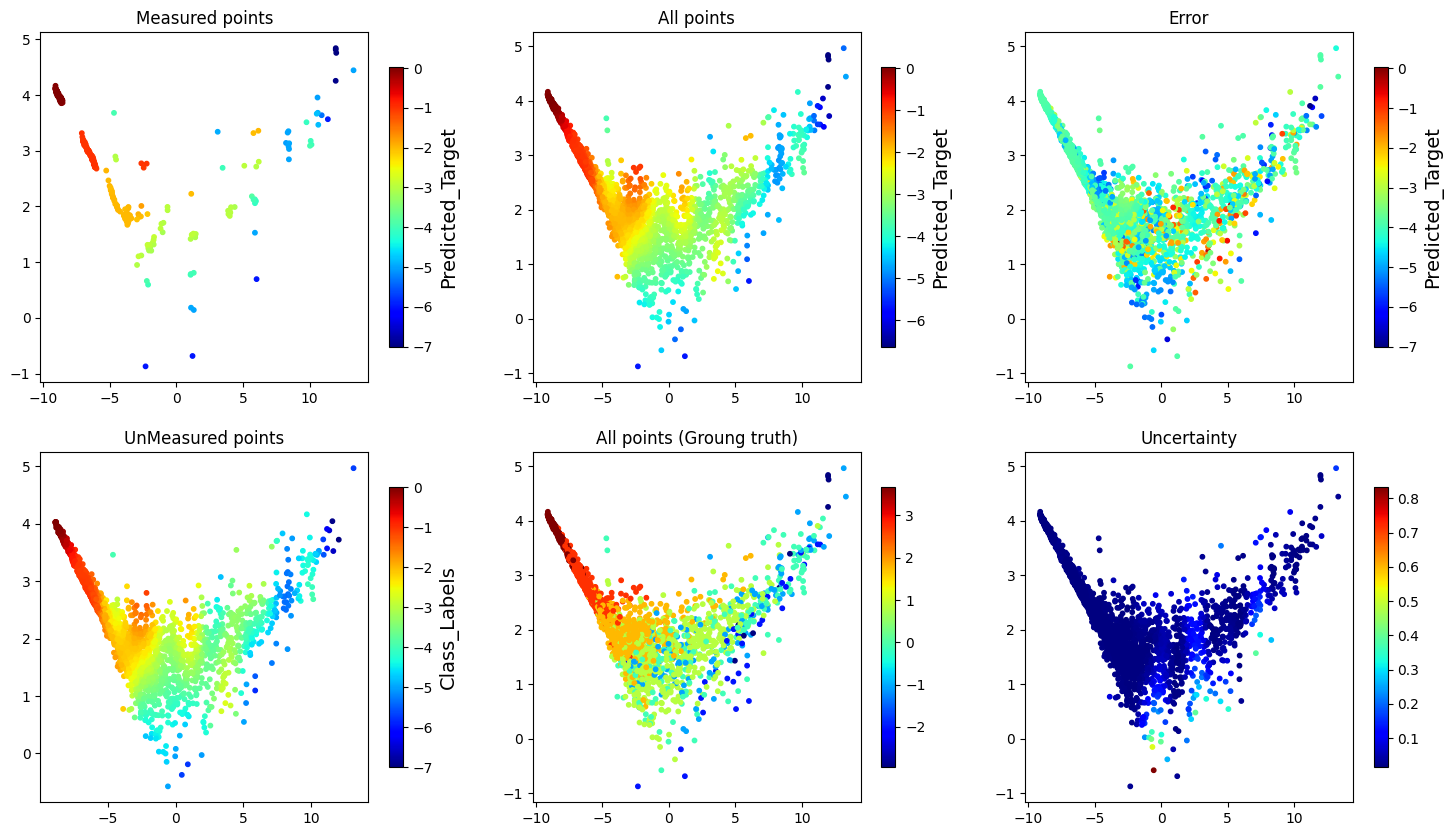

In [43]:
embeded_train5 = dkl_BO_5.embed(X5_train)  # Measured points
embeded_unmeasured5 = dkl_BO_5.embed(X5_unmeasured)  # Unmeasured points
embeded15 = dkl_BO_5.embed(X5)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,10))

im = ax[0,0].scatter(embeded_train5[:, 1], embeded_train5[:, 0], s=10, c = predmean_train5, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_unmeasured5[:, 1], embeded_unmeasured5[:, 0], s=10,
                c = predmean_unmeas5, cmap = 'jet')
ax[1,0].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predmean15, cmap = 'jet')
ax[0,1].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = targets5, cmap = 'jet')
ax[1,1].set_title('All points (Groung truth)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predmean15 - targets5, cmap = 'jet')
ax[0,2].set_title('Error')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
#cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predstd15, cmap = 'jet')
ax[1,2].set_title('Uncertainty')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
#cbar.set_label("Wt", fontsize=14)
cbar.ax.tick_params(labelsize=10)

And now we have done it as active learning. Note that in this case the predicted targets form two regions in latent space. So, th elatent distirbution is much better behaved then for VAE, but not as good as for the full DKL. Still, we learned only with 1% of the data.

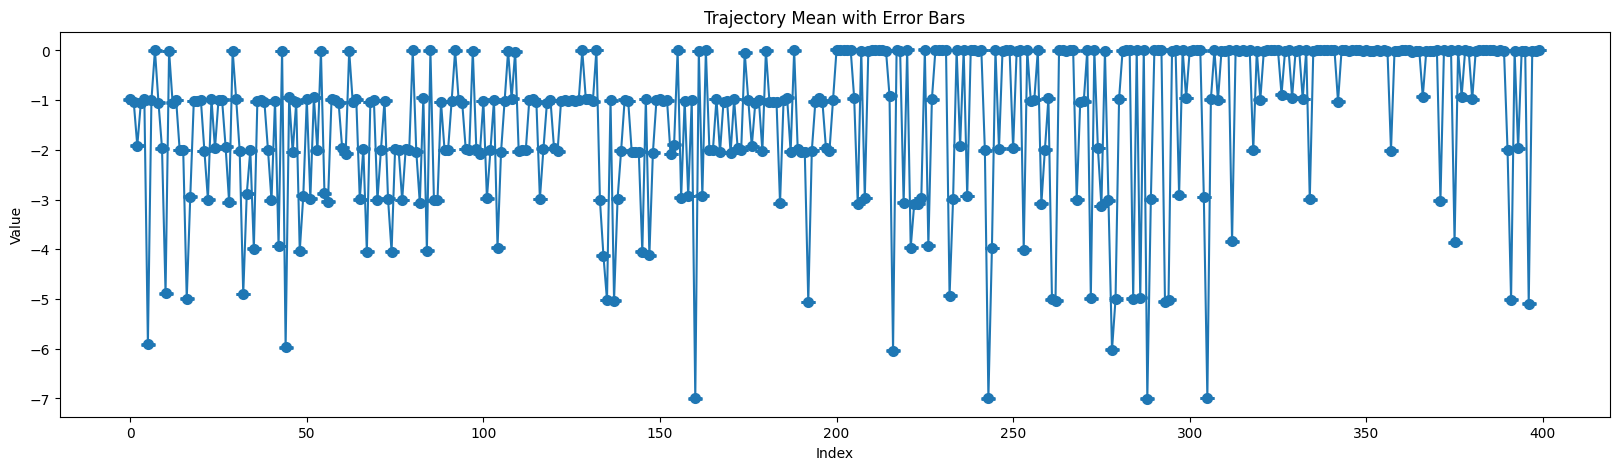

In [44]:
num_t = len(traj_mean5)
x = np.arange(traj_mean5[num_t-1].shape[0])

# Plotting the mean with error bars
fig, _ = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 5))
plt.errorbar(x, traj_mean5[num_t-1], yerr=traj_std5[num_t-1], fmt='-o', capsize=5, elinewidth=2, markeredgewidth=2)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Trajectory Mean with Error Bars')
plt.show()

In [45]:
original_array = np.array(one_hot_vectors).reshape(-1, s2*s3)
search_array = X5_train

import numpy as np

# Sample data (replace with your actual data)
# original_array = np.random.rand(5000, p)  # Original array of shape (5000, p)
# search_array = np.random.rand(m, p)       # Search array of shape (m, p)

def find_indices(original, search):
    indices = []
    for row in search:
        # Find the index of the row in the original array
        index = np.where((original == row).all(axis=1))[0]
        if index.size > 0:
            indices.append(index[0])
        else:
            indices.append(-1)  # -1 indicates not found
    return np.array(indices)

# Find indices
indices = find_indices(original_array, search_array)

print(indices)

[1176 4168 4178 2440 3819  142 1084 4149 3318 4603 1828 4097 1122 1160
  159 4710 3609 4636 1519 2630 4058 3103 4701  138 3012  871 3885  453
 2709 1979 4759 3569 3045 4591 3351 2625 2655 4213 2986  562  812 2175
 1688 3328 3382 1596 1692  520 3195 1085 3034 3431 3883 4372 1087 3512
 3658 1281 1224 3240  799  405 1710  214 2608 1834  308 1014 1414 3652
 3180  134 4829 1108 4776 2768 3341 4422 1066  965  891  906 2149 4579
 3474 1012 4462  661 4340 2006  148 2778 1011 4882  675  298 3016  446
 3618 1223 3909 3225  348 4808 3788 4359 3407 4264 4530 1833 2443 3697
 4574 1547 4176 4479  771 4413 4647  302 4196 4445 3725  578 3202 2542
  938 4056 4070 1894 2477 4143  882 2805 4837 2104   42 4576  530 2933
  533 4946  202 2552 2898 1001 2263 4491  896 1329 1309 2810 1328 3432
 1450 1385 1784   49 1590  137 4684 1761 2211   12 4171 2620 2455 2670
  130   30 2300 4791 4468 2378 1632 2069 4747 2329  491 2307 2648 1835
 4357 2940 2450 3703 4456  125 4673 3036  154 2692 4290 2160 3175 1410
 4905 

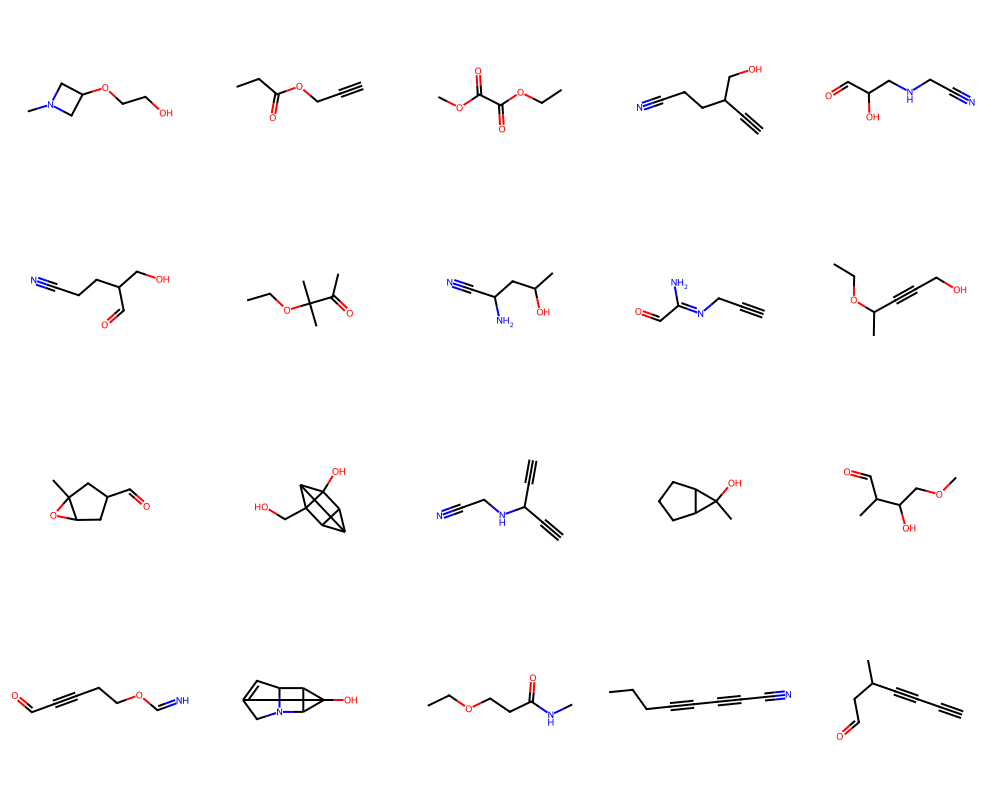

In [63]:
# Using the find_indices function from the previous response
indices_all = find_indices(original_array, search_array)
indices = indices_all[-20:]

# Filter out -1 (not found) indices
valid_indices = [index for index in indices if index != -1]

# Retrieve the corresponding rows in the DataFrame
corresponding_rows = df_filtered.iloc[valid_indices]

# Extract SMILES strings
smiles_list = corresponding_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects
molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(200, 200), useSVG=True)
img

# DKL on molecules (5D latent space)

In [48]:
molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X5 = np.asarray(molecules).reshape([-1,s2*s3])
print(X5.shape)

#Actual target
targets5 = df_filtered['ringct'].values

(4993, 567)


In [49]:
rng_key_5D, rng_key_predict_5D = gpax.utils.get_keys()
dkl_5D = gpax.viDKL(s2*s3, 5, 'RBF')
dkl_5D.fit(rng_key_5D, X5, targets5)

100%|██████████| 1000/1000 [02:05<00:00,  7.99it/s, init loss: 48766.1766, avg. loss [951-1000]: 36145.3442]



Inferred GP kernel parameters
k_length         [1.4596 1.1678 1.7818 2.5187 2.139 ]
k_scale          2.329
noise            0.009300000000000001


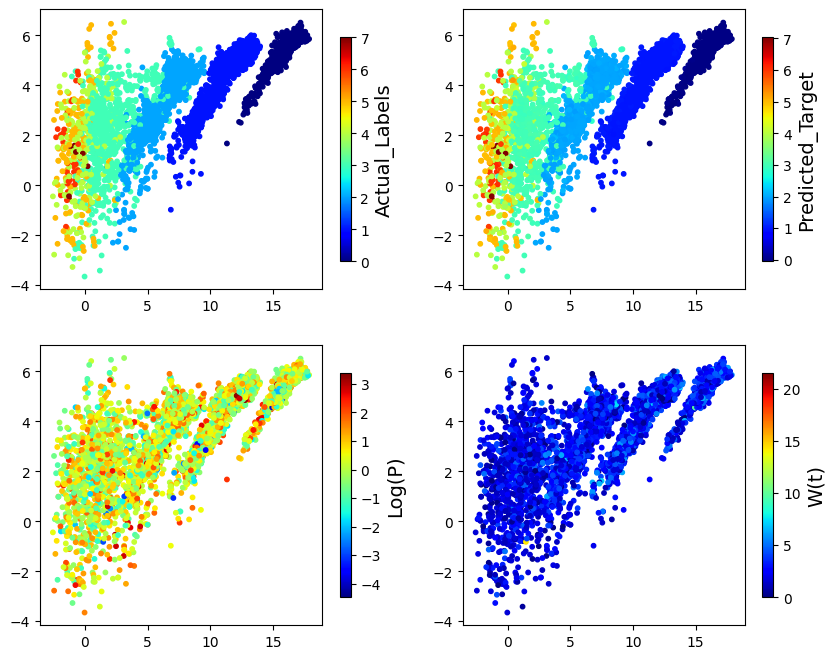

In [50]:
embeded_5D = dkl_5D.embed(X5)
pred_mean5D, pred_var5D = dkl_5D.predict_in_batches(rng_key_predict_5D, X5, batch_size=batch_size_reconstruct)
pred_std5 = jnp.sqrt(pred_var5D)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5D[:, 1], embeded_5D[:, 0], s=10, c = targets5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5D[:, 1], embeded_5D[:, 0], s=10, c = pred_mean5D, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5D[:, 1], embeded_5D[:, 0], s=10, c = df_filtered['mole_logp'].values,
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5D[:, 1], embeded_5D[:, 0], s=10, c = df_filtered['dipole_moment'].values, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("W(t)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [51]:
pred_mean5D.shape, pred_var5D.shape, embeded_5D.shape

((4993,), (4993,), (4993, 5))

In [52]:
from sklearn.manifold import TSNE

# Use t-SNE to project the data to 2D
tsne = TSNE(n_components=2, random_state=0)
embeded_2D = tsne.fit_transform(embeded_5D)

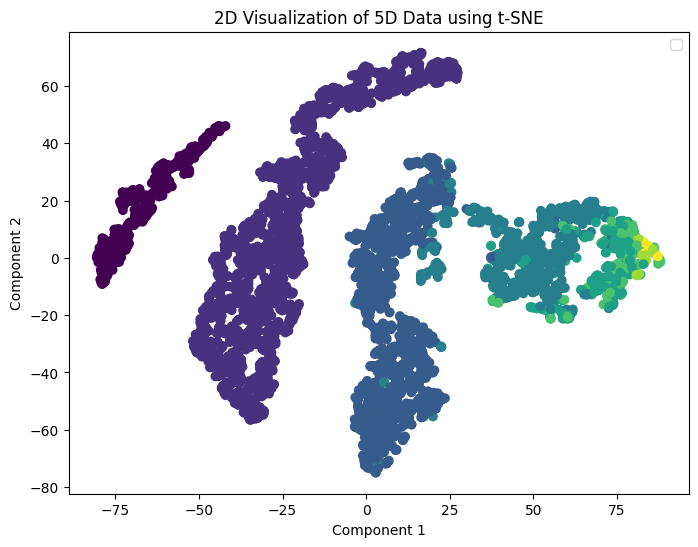

In [53]:
# Plot the projected data
plt.figure(figsize=(8, 6))
plt.scatter(embeded_2D[:, 0], embeded_2D[:, 1], c = targets5)
plt.legend()
plt.title('2D Visualization of 5D Data using t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()